In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from ipywidgets import interact
plotly.offline.init_notebook_mode(connected=True)

from src.data.box import GravityHoleBall
from src.data.generate import generate_gravity_hole_ball_images

from src.utils.utils import add_spatial_encoding
from src.utils.node import  BatchGetterMultiImages, train_convnode_with_batch, train_convnode_with_batch_and_latent_supervision
from src.utils.viz import  display_convnode_trajectory

from src.models.convnode import ConvNodeWithBatch#, LatentRegularizerLoss


In [2]:
MARGIN_MIN = 5
MIN_INIT_VELOCITY = 200.
WIDTH, HEIGHT = 28, 28
RADIUS = 3

infos = {
    "MARGIN_MIN":MARGIN_MIN,
    "MIN_INIT_VELOCITY":MIN_INIT_VELOCITY,
    "WIDTH":WIDTH,
    "HEIGHT":HEIGHT,
    "RADIUS":RADIUS
}

x = WIDTH/4.
y = HEIGHT/4.
vx = 0.
vy = 0.

box = GravityHoleBall(x, y, vx, vy, (WIDTH, HEIGHT),RADIUS)


Num_pos_velocity = 1
N = 1500
N_frames = 300 + Num_pos_velocity
dt = 1./N_frames

times = np.arange(0, N_frames*dt, dt)

# encoded_trajectory = generate_gravity_hole_ball_positions(box, N=N, N_frames=N_frames, dt=dt)[:,:,:]
# print(encoded_trajectory.shape)
print("-"*50)
print("Generating images...")
images = generate_gravity_hole_ball_images(box, N=N, N_frames=N_frames, dt=dt, infos=infos).reshape(-1, 1, HEIGHT, WIDTH)
print(images.shape)
# dataset = [(image, 0) for image in dataset]
# dataset = add_spatial_encoding(dataset)
# print(len(dataset), len(dataset[0]), dataset[0][0].shape)
images = torch.from_numpy(add_spatial_encoding(images)).float().reshape(N, -1, 3, HEIGHT, WIDTH)
print(images.shape)


--------------------------------------------------
Generating images...


100%|██████████| 1500/1500 [01:17<00:00, 19.48it/s]


(451500, 1, 28, 28)
torch.Size([1500, 301, 3, 28, 28])


In [3]:
print("-"*50)
print("Creating model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
size = 28
latent_dim = 16
in_channels = 3
ode_data_dim = latent_dim
ode_hidden_dim = 128
augment_dim = 0
time_dependent=False
ode_non_linearity='relu' 
conv_activation=nn.ReLU()
latent_activation=None
stack_size=1

conv_ode = ConvNodeWithBatch(device, size, latent_dim, in_channels,
    ode_hidden_dim, ode_data_dim, augment_dim=augment_dim, time_dependent=time_dependent,
    ode_non_linearity=ode_non_linearity, ode_linear_layer=False, conv_activation=conv_activation,
    latent_activation=latent_activation, stack_size=stack_size)

# pathConvODE = "models/AE_ODE/ConvODE/conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}_with_lambda_decay.pt".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
# pathConvODE = "ssh/conv_ode_1_ball_latent_32_hidden_ode_128_stack_1_conv_activation_ReLU()_with_lambda_decay_together.pt"
# pathConvODE = "ssh/conv_ode_1_ball_latent_32_hidden_ode_128_stack_1_conv_activation_ReLU()_with_lambda_decay_ODE_and_decoder.pt"
# # pathConvODE = "conv_ode_1_ball_latent_10_hidden_ode_128_stack_1_conv_activation_ReLU()_with_lambda_decay_together_v2.pt"


pathConvODE = "conv_ode_1_ball_latent_16_hidden_ode_128_stack_1_conv_activation_ReLU()_last_model_no_reg.pt"
print(conv_ode.load_state_dict(torch.load(pathConvODE, map_location=device)))

--------------------------------------------------
Creating model...
--------------------------------------------------
Creating ConvAE...
Number of parameters in the encoder model: 127568
Number of parameters in the decoder model: 127715
--------------------------------------------------
Creating ANODENet...
Number of parameters in the model: 25392
<All keys matched successfully>


In [4]:
print("-"*50)
print("Creating tools to train...")
batch_size = 32
batch_time = 200
n_stack = 1
total_length = N_frames - Num_pos_velocity
getter = BatchGetterMultiImages(batch_time, batch_size, n_stack, total_length, dt, images, frac_train=1.)

--------------------------------------------------
Creating tools to train...


# Loss without latent supervision

In [5]:
from src.models.convnode import TimeDistributed

class LatentRegularizerLoss(nn.Module):
    def __init__(self, device, reg_lambda, step_decay=1, decay_rate=0.9, weighted=False):
        super(LatentRegularizerLoss, self).__init__()
        self.device = device
        self.reg_lambda = reg_lambda
        
        if weighted:
            self.image_loss = nn.MSELoss(reduction="none")
        else:
            self.image_loss = nn.MSELoss()
        
        self.step_decay = step_decay
        self.decay_rate = decay_rate
        self._step = 0
        self.weighted = weighted

    def forward(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)
        # print(loss_img.shape)
        if self.weighted:
            weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
            # print(weights.shape)
            # print(weights.shape)
            # print(weights)
            weights = (0.0 + 5 * weights)
            # print(weights)
            loss_img = loss_img.mean(dim=(2,3,4))*weights 
        loss_img = loss_img.mean(dim=-1).mean(dim=-1)

        loss_reg = torch.linalg.norm(latent_z, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        # print("loss_img: ", loss_img)
        # print("loss_reg: ", loss_reg)
        return loss_img + self.reg_lambda * loss_reg
    

    def step(self):
        self._step +=1
        if self._step % self.step_decay == 0:
            self.reg_lambda *= self.decay_rate
            

    def forward_print(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)

        if self.weighted:
            weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
            # print(weights.shape)
            # print(weights.shape)
            # print(weights)
            weights = (0.1 + 2 * weights)
            # print(weights)
            loss_img_weighted = loss_img.mean(dim=(2,3,4))*weights 
            loss_img = loss_img.mean(dim=(2,3,4))

        loss_reg = torch.linalg.norm(latent_z, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        print("-"*30, "Loss prints", "-"*30)
        print("loss_img unweighted: ", loss_img.mean(dim=-1).mean(dim=-1))
        if self.weighted:
            print("loss_img weighted: ", loss_img_weighted.mean(dim=-1).mean(dim=-1))
        print("loss_reg: ", self.reg_lambda * loss_reg)
        print("reg_lambda: ",self.reg_lambda)
        print("-"*73)
        return None

class FinalStateWeightingMSE(nn.Module):
    def __init__(self):
        super(FinalStateWeightingMSE, self).__init__()
        # self.mse = TimeDistributedLoss(nn.MSELoss(),
        #                     4
        # )

        self.mse = nn.MSELoss(reduction="none")
        
    def forward(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.mse(pred_images, true_images).mean(dim=(2,3,4))
        # print(loss_img.shape)
        weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
        # print(weights.shape)
        # print(weights)
        weights = (0.0 + 5 * weights)
        # print(weights)
        loss_img = loss_img*weights
        # print(loss_img)
        return loss_img.mean(dim=-1).mean(dim=-1)

    def step(self):
        pass

    def forward_print(self, latent_z, pred_images, true_images):
        loss_img = self.mse(pred_images, true_images).mean(dim=(2,3,4))
        # print(loss_img.shape)
        weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
        # print(weights.shape)
        # print(weights)
        weights = (0.1 + 2 * weights)
        # print(weights)
        loss_img_weighted = loss_img*weights
        # print(loss_img)
        print("-"*30, "Loss prints", "-"*30)
        print("loss_img unweighted: ", loss_img.mean(dim=-1).mean(dim=-1))
        print("loss_img weighted: ", loss_img_weighted.mean(dim=-1).mean(dim=-1))
        print("-"*73)
        return loss_img_weighted.mean(dim=-1).mean(dim=-1), loss_img.mean(dim=-1).mean(dim=-1)


optimizerEnc = torch.optim.Adam(conv_ode.encoder.parameters(), lr=1e-6)
optimizerDec = torch.optim.Adam(conv_ode.decoder.parameters(), lr=1e-6)
optimizerODE = torch.optim.Adam(conv_ode.node.parameters(), lr=1e-5) #1e-4)
optimizers = [optimizerEnc, optimizerDec, optimizerODE]
scheduler = torch.optim.lr_scheduler.StepLR(optimizerODE, step_size=2000, gamma=0.9)

reg_lambda = 0.#4.3e-6
loss_fn = LatentRegularizerLoss(device, reg_lambda, step_decay=10000, decay_rate=0.099, weighted=True)
# 4.722366482869652e-05
# Adam (
# Parameter Group 0
#     amsgrad: False
#     betas: (0.9, 0.999)
#     eps: 1e-08
#     initial_lr: 0.0001
#     lr: 1.667718169966658e-05
#     weight_decay: 0
# )


In [6]:
# loss_fn = FinalStateWeightingMSE()
inputs = torch.zeros(3, 10, in_channels, size, size).to(device)
outputs = torch.zeros(3, 10, in_channels, size, size).to(device)
latent_z = torch.zeros(1)
loss_fn(latent_z, inputs, outputs)
loss_fn.forward_print(latent_z, inputs, outputs)

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0., device='cuda:0')
loss_img weighted:  tensor(0., device='cuda:0')
loss_reg:  tensor(0.)
reg_lambda:  0.0
-------------------------------------------------------------------------


# Loss with latent supervision

In [92]:
class LatentRegularizerLossWithLatent(nn.Module):
    def __init__(self, device, reg_lambda, latent_lambda, step_decay=1, decay_rate=0.9, weighted=False):
        super(LatentRegularizerLossWithLatent, self).__init__()
        self.device = device
        self.reg_lambda = reg_lambda
        self.latent_lambda = latent_lambda
        
        if weighted:
            self.image_loss = nn.MSELoss(reduction="none")
        else:
            self.image_loss = nn.MSELoss()
        
        self.step_decay = step_decay
        self.decay_rate = decay_rate
        self._step = 0
        self.weighted = weighted

    def forward(self, pred_latent, true_latent, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)
        loss_latent = self.image_loss(pred_latent, true_latent)
        # print(loss_img.shape)
        if self.weighted:
            weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
            # print(weights.shape)
            # print(weights.shape)
            # print(weights)
            weights = (0.0 + 5 * weights)
            # print(weights)
            loss_img = loss_img.mean(dim=(2,3,4))*weights 

            loss_latent = loss_latent.mean(dim=-1)*weights

        loss_img = loss_img.mean(dim=-1).mean(dim=-1)

        loss_latent = loss_latent.mean(dim=-1).mean(dim=-1)

        loss_reg = torch.linalg.norm(true_latent, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        # print("loss_img: ", loss_img)
        # print("loss_reg: ", loss_reg)
        return loss_img + self.reg_lambda * loss_reg + self.latent_lambda*loss_latent
    

    def step(self):
        self._step +=1
        if self._step % self.step_decay == 0:
            self.reg_lambda *= self.decay_rate
            

    def forward_print(self, pred_latent, true_latent, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)
        loss_latent = self.image_loss(pred_latent, true_latent)

        if self.weighted:
            weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
            # print(weights.shape)
            # print(weights.shape)
            # print(weights)
            weights = (0.1 + 2 * weights)
            # print(weights)
            loss_img_weighted = loss_img.mean(dim=(2,3,4))*weights 
            loss_img = loss_img.mean(dim=(2,3,4))

            loss_latent_weighted = loss_latent.mean(dim=-1)*weights
            loss_latent = loss_latent.mean(dim=-1)
        


        

        loss_reg = torch.linalg.norm(true_latent, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        print("-"*30, "Loss prints", "-"*30)
        print("loss_img unweighted: ", "{:.6f}".format(loss_img.mean(dim=-1).mean(dim=-1).item()))
        if self.weighted:
            print("loss_img weighted: ", "{:.6f}".format((loss_img_weighted.mean(dim=-1).mean(dim=-1)).item()))

        print("loss_latent unweighted: ", "{:.6f}".format((self.latent_lambda*loss_latent.mean(dim=-1).mean(dim=-1)).item()))
        if self.weighted:
            print("loss_latent weighted: ", "{:.6f}".format((self.latent_lambda*loss_latent_weighted.mean(dim=-1).mean(dim=-1)).item()))
        print("loss_reg: ", "{:.6f}".format((self.reg_lambda * loss_reg).item()))
        print("reg_lambda: ","{:.6f}".format((self.reg_lambda)))
        print("-"*73)
        return None

reg_lambda = 0 #5e-3
latent_lambda = 5
loss_fn = LatentRegularizerLossWithLatent(device, reg_lambda, latent_lambda, step_decay=3000, decay_rate=0.8, weighted=False)

In [86]:
# loss_fn = FinalStateWeightingMSE()
inputs = torch.randn(3, 10, in_channels, size, size).to(device)
outputs = torch.randn(3, 10, in_channels, size, size).to(device)
pred_latent = torch.randn(3, 10, 2).to(device)
true_latent = torch.randn(3, 10, 2).to(device)

print(loss_fn(pred_latent, true_latent, inputs, outputs))
loss_fn.forward_print(pred_latent, true_latent, inputs, outputs)

tensor(14.9898, device='cuda:0')
------------------------------ Loss prints ------------------------------
loss_img unweighted:  2.011830
loss_latent unweighted:  12.977978
loss_reg:  0.000000
reg_lambda:  0.000000
-------------------------------------------------------------------------


# Training process

In [7]:
root = None #"images/AE_ODE/Gravity/MultiTrajectories/Together/"
name = None # "conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
display_fn = lambda i, model, out_display, getter, final_time, dt: display_convnode_trajectory(i, model, out_display, getter, final_time, dt, root=root, name=name)
# display_fn(0, conv_ode, latent_dim, getter, N_frames - Num_pos_velocity, dt)

## Training with latent supervision

In [94]:
optimizer = torch.optim.Adam(conv_ode.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)

--------------------------------------------------
Training...


  1%|          | 499/50000 [01:10<1:59:34,  6.90it/s, Loss: 0.01213414]

The graphs at epoch 500


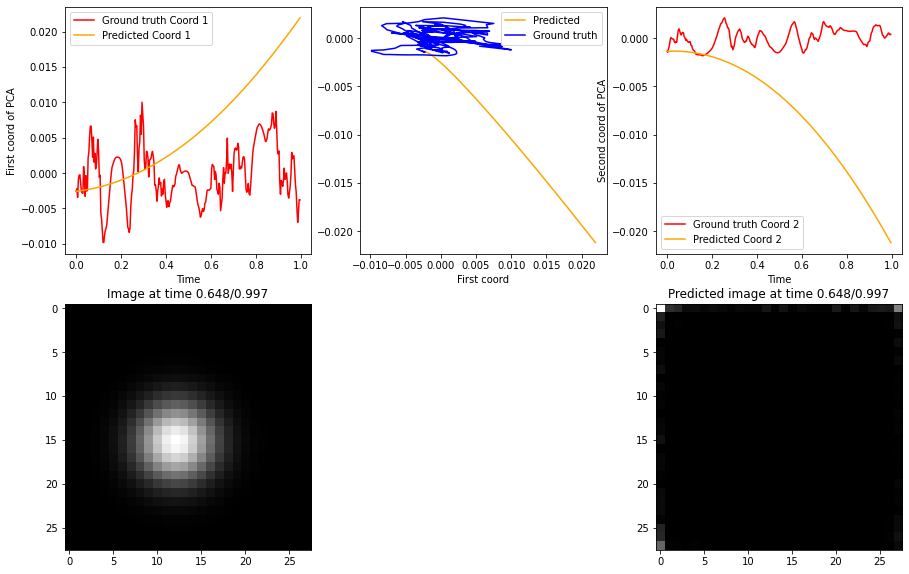

Display loss: 0.03165094:   1%|          | 501/50000 [01:11<3:25:13,  4.02it/s, Loss: 0.01109493]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  0.012119
loss_latent unweighted:  0.000015
loss_reg:  0.000000
reg_lambda:  0.000000
-------------------------------------------------------------------------


Display loss: 0.03165094:   2%|▏         | 999/50000 [02:22<1:56:09,  7.03it/s, Loss: 0.01155081]

The graphs at epoch 1000


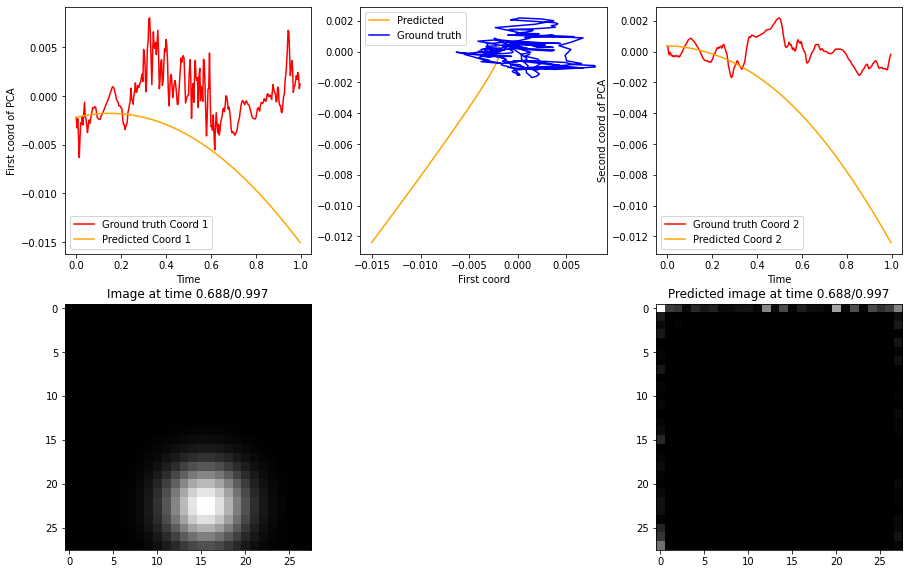

Display loss: 0.01127540:   2%|▏         | 1001/50000 [02:23<3:20:13,  4.08it/s, Loss: 0.01143022]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  0.011544
loss_latent unweighted:  0.000007
loss_reg:  0.000000
reg_lambda:  0.000000
-------------------------------------------------------------------------


Display loss: 0.01127540:   2%|▏         | 1141/50000 [02:43<1:56:41,  6.98it/s, Loss: 0.01146191]


KeyboardInterrupt: 

In [95]:
print("-"*50)
print("Training...")
epochs = 50000

# for param in conv_ode.node.parameters():
#     param.requires_grad = True
    
train_convnode_with_batch_and_latent_supervision(conv_ode, optimizer, scheduler, epochs,
    getter, loss_fn=loss_fn, display=500, display_results_fn=display_fn)

## Training without latent supervision

--------------------------------------------------
Training...


  2%|▏         | 999/50000 [03:35<2:56:40,  4.62it/s, Loss: 0.00125766]

The graphs at epoch 1000


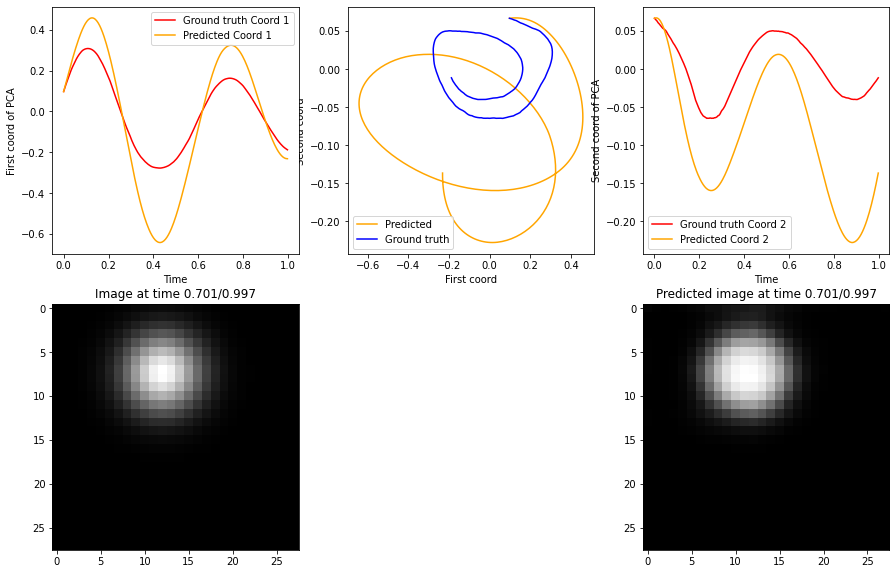

Display loss: 0.00118392:   2%|▏         | 1000/50000 [03:36<5:21:36,  2.54it/s, Loss: 0.00125766]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00118392:   4%|▍         | 1999/50000 [07:12<2:53:52,  4.60it/s, Loss: 0.00074870]

The graphs at epoch 2000


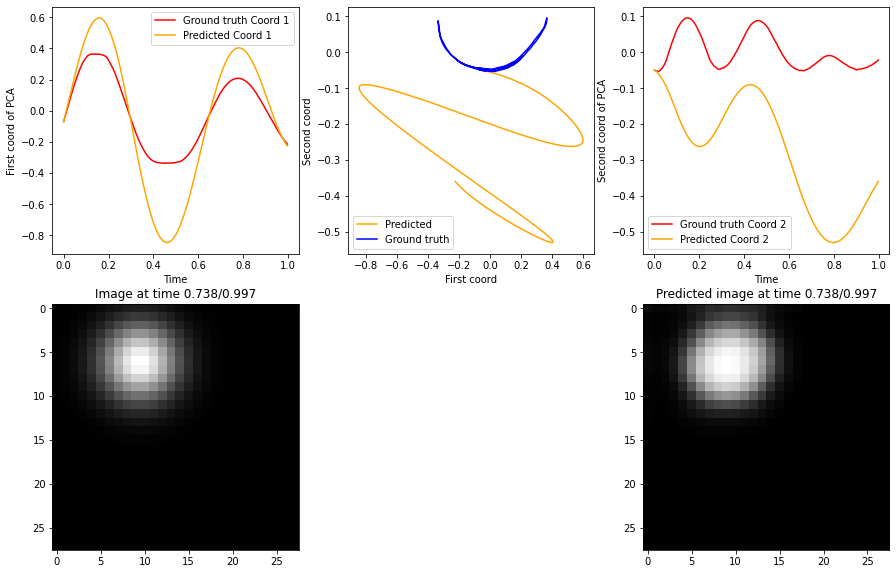

Display loss: 0.00114682:   4%|▍         | 2000/50000 [07:13<5:26:59,  2.45it/s, Loss: 0.00074870]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00114682:   6%|▌         | 2999/50000 [10:50<2:50:31,  4.59it/s, Loss: 0.00177942]

The graphs at epoch 3000


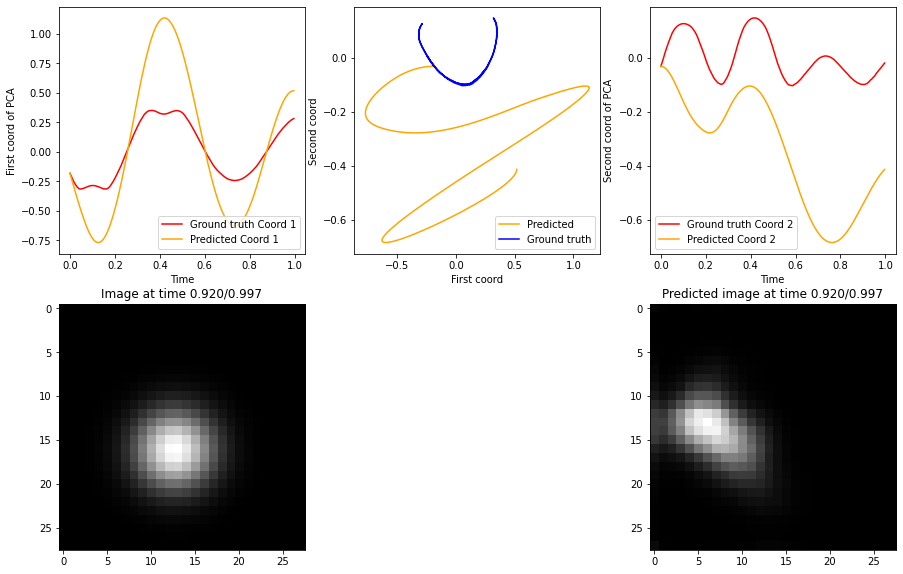

Display loss: 0.00116768:   6%|▌         | 3000/50000 [10:51<5:02:08,  2.59it/s, Loss: 0.00177942]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00116768:   8%|▊         | 3999/50000 [14:29<2:48:46,  4.54it/s, Loss: 0.00128087]

The graphs at epoch 4000


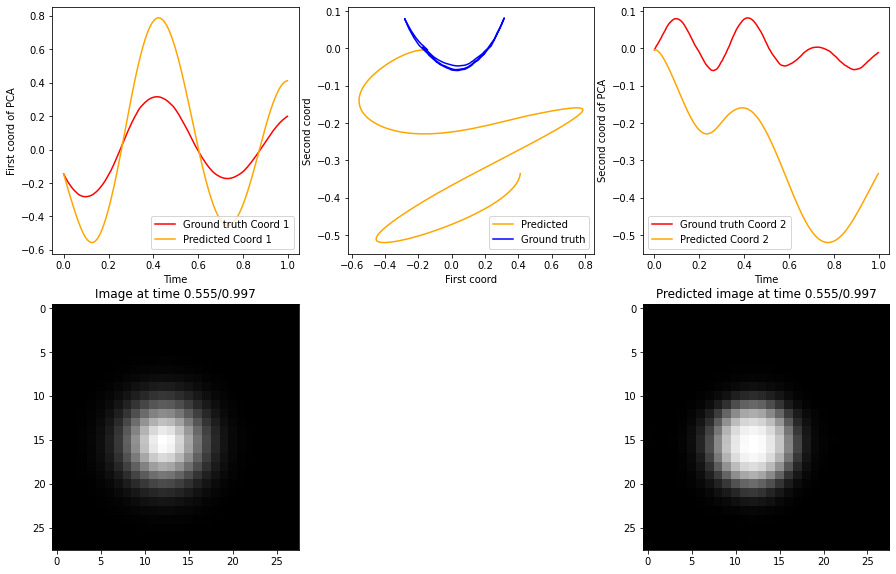

Display loss: 0.00115067:   8%|▊         | 4000/50000 [14:29<5:04:15,  2.52it/s, Loss: 0.00128087]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00115067:  10%|▉         | 4999/50000 [18:07<2:45:32,  4.53it/s, Loss: 0.00186116]

The graphs at epoch 5000


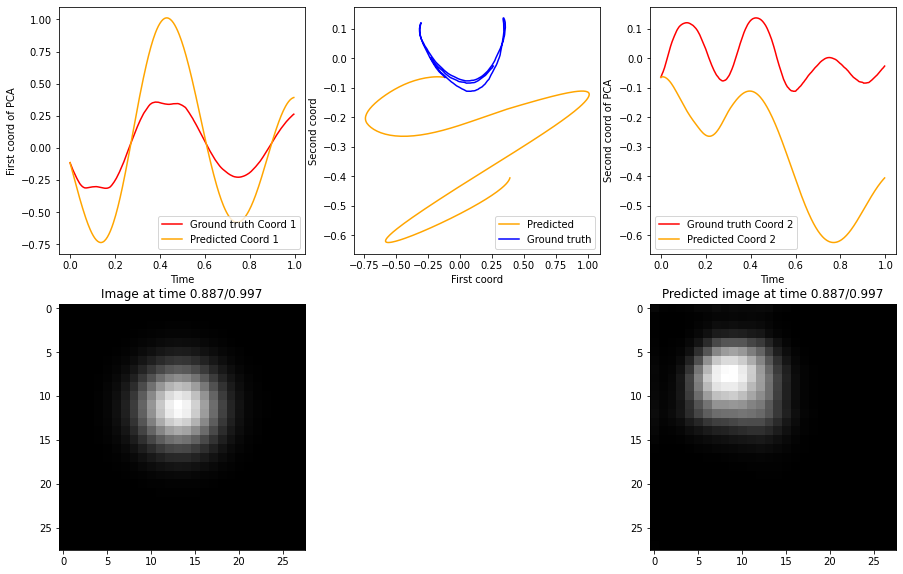

Display loss: 0.00115101:  10%|█         | 5000/50000 [18:08<5:18:46,  2.35it/s, Loss: 0.00186116]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00115101:  12%|█▏        | 5999/50000 [21:45<2:38:49,  4.62it/s, Loss: 0.00093543]

The graphs at epoch 6000


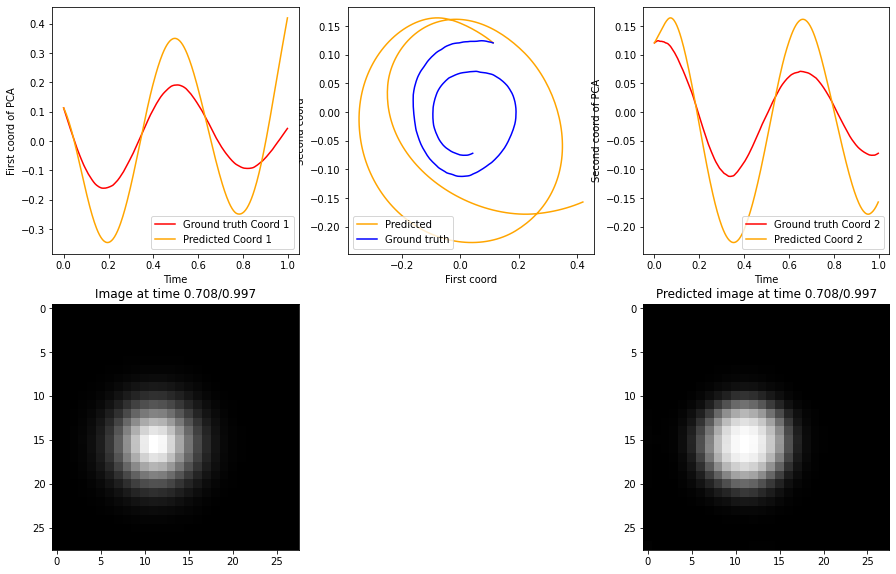

Display loss: 0.00114830:  12%|█▏        | 6000/50000 [21:46<4:45:35,  2.57it/s, Loss: 0.00093543]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00114830:  14%|█▍        | 6999/50000 [25:23<2:36:44,  4.57it/s, Loss: 0.00078726]

The graphs at epoch 7000


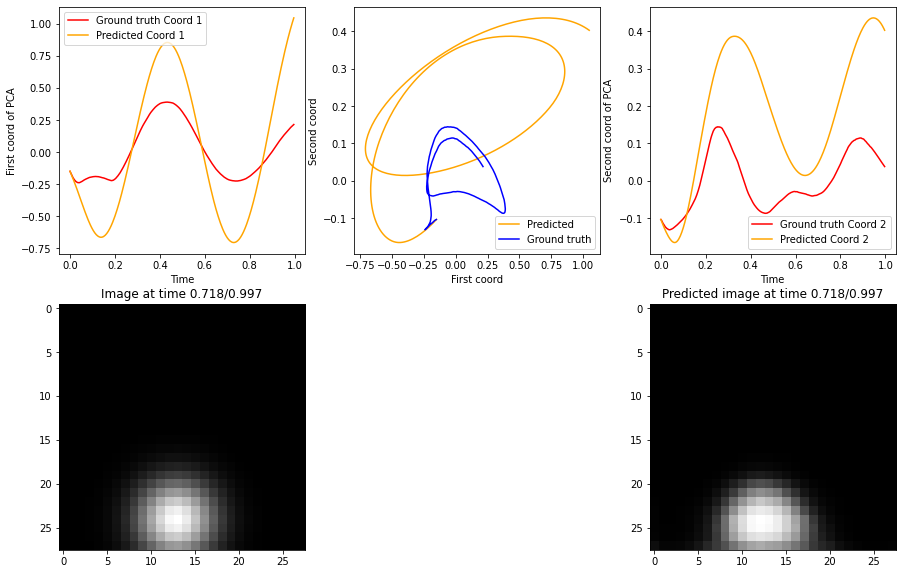

Display loss: 0.00111696:  14%|█▍        | 7000/50000 [25:24<5:03:08,  2.36it/s, Loss: 0.00078726]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00111696:  16%|█▌        | 7999/50000 [29:02<2:32:10,  4.60it/s, Loss: 0.00152996]

The graphs at epoch 8000


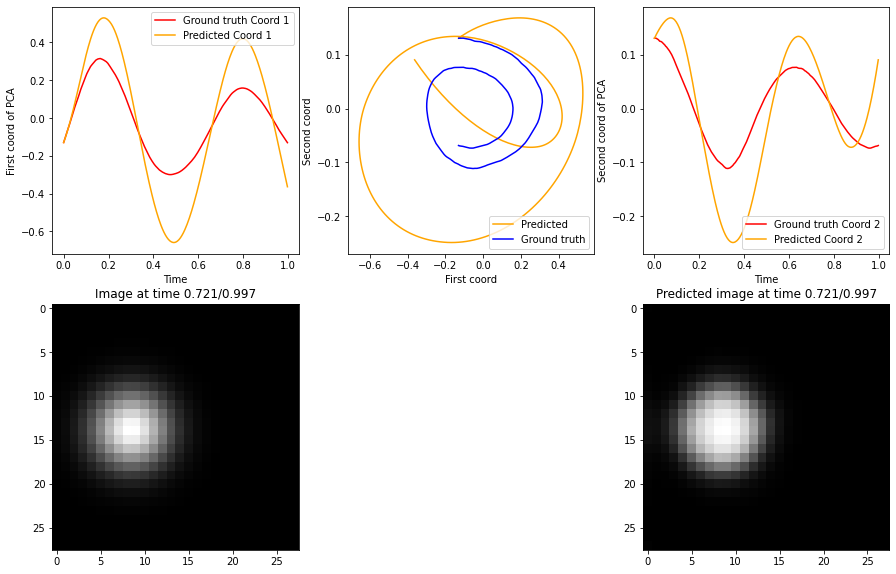

Display loss: 0.00111976:  16%|█▌        | 8000/50000 [29:03<4:31:15,  2.58it/s, Loss: 0.00152996]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00111976:  18%|█▊        | 8999/50000 [32:41<2:29:13,  4.58it/s, Loss: 0.00105297]

The graphs at epoch 9000


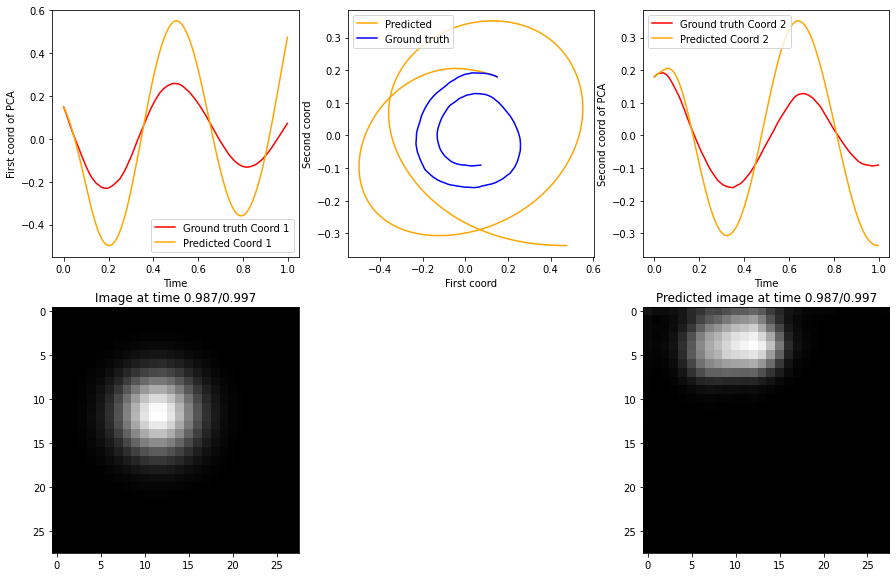

Display loss: 0.00111505:  18%|█▊        | 9000/50000 [32:41<4:28:04,  2.55it/s, Loss: 0.00105297]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00111505:  20%|█▉        | 9999/50000 [36:19<2:24:42,  4.61it/s, Loss: 0.00068693]

The graphs at epoch 10000


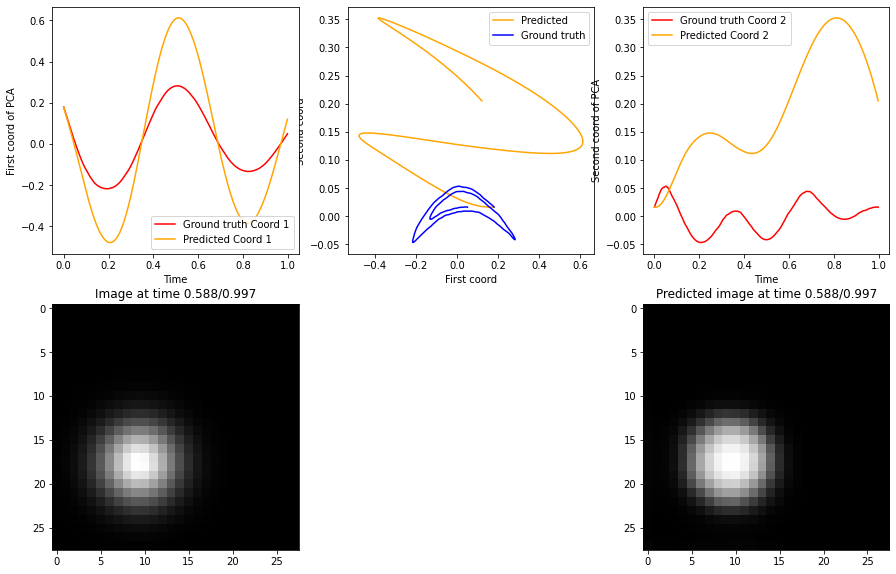

Display loss: 0.00110383:  20%|██        | 10000/50000 [36:19<4:19:09,  2.57it/s, Loss: 0.00068693]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00110383:  22%|██▏       | 10999/50000 [39:57<2:22:17,  4.57it/s, Loss: 0.00066710]

The graphs at epoch 11000


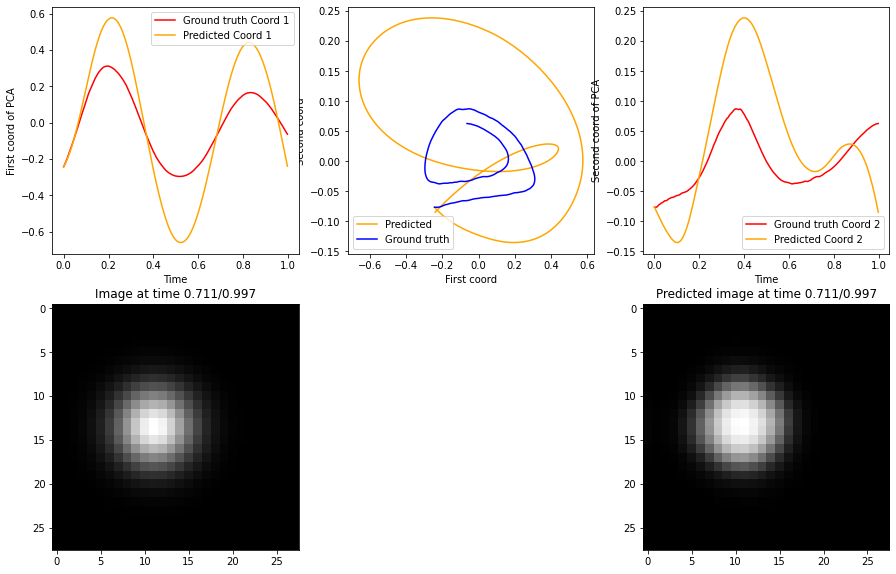

Display loss: 0.00111769:  22%|██▏       | 11000/50000 [39:57<4:30:18,  2.40it/s, Loss: 0.00066710]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00111769:  24%|██▍       | 11999/50000 [43:35<2:17:14,  4.61it/s, Loss: 0.00158702]

The graphs at epoch 12000


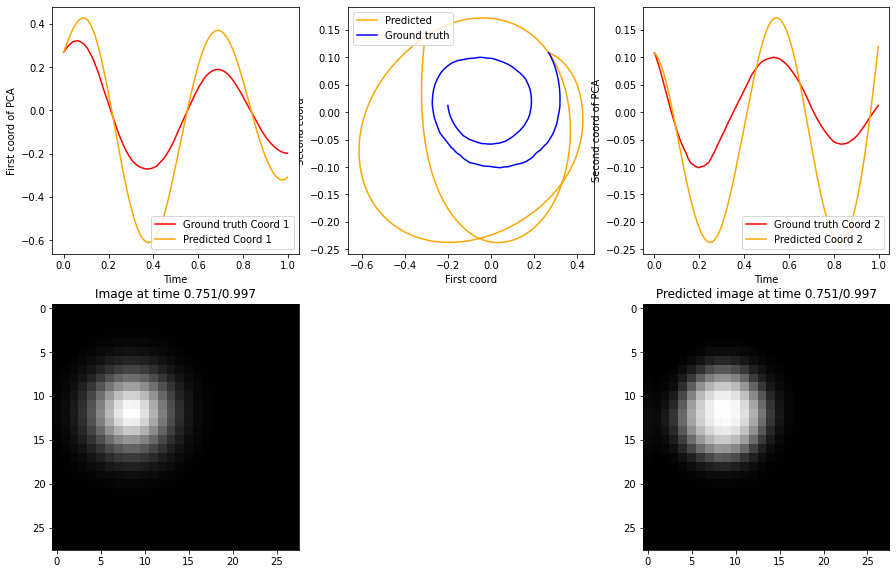

Display loss: 0.00110651:  24%|██▍       | 12000/50000 [43:36<4:21:23,  2.42it/s, Loss: 0.00158702]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00110651:  26%|██▌       | 12999/50000 [47:14<2:14:37,  4.58it/s, Loss: 0.00152370]

The graphs at epoch 13000


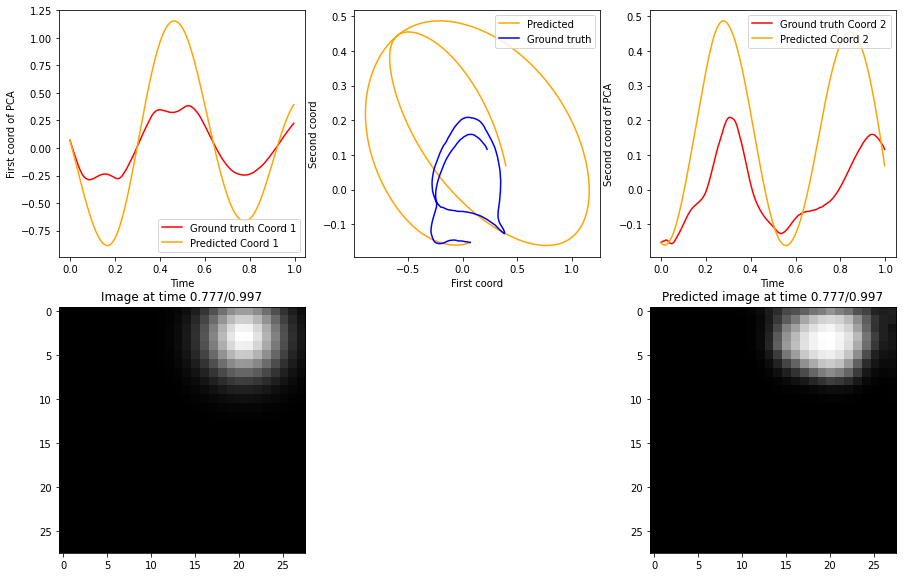

Display loss: 0.00108645:  26%|██▌       | 13000/50000 [47:15<4:01:27,  2.55it/s, Loss: 0.00152370]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00108645:  28%|██▊       | 13999/50000 [50:52<2:10:29,  4.60it/s, Loss: 0.00102049]

The graphs at epoch 14000


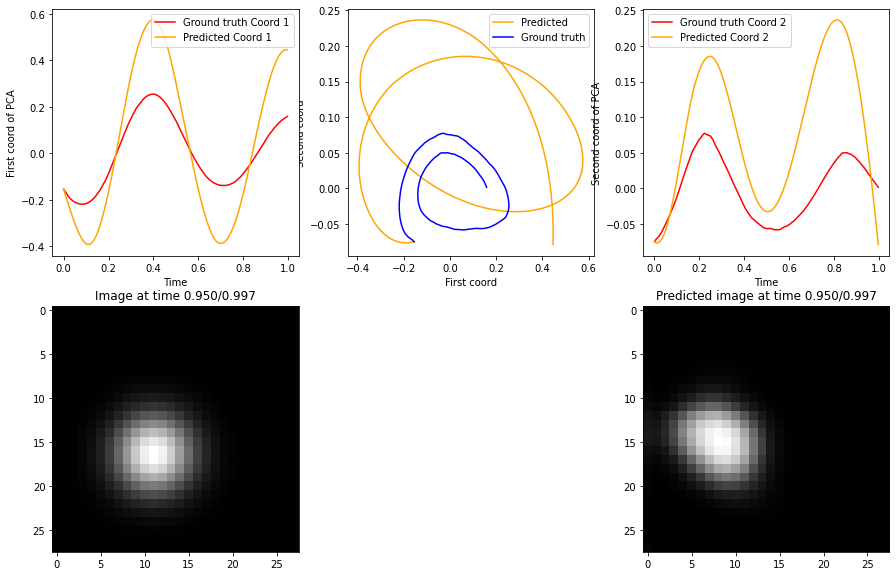

Display loss: 0.00108329:  28%|██▊       | 14000/50000 [50:53<3:53:16,  2.57it/s, Loss: 0.00102049]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00108329:  30%|██▉       | 14999/50000 [54:31<2:07:43,  4.57it/s, Loss: 0.00066483]

The graphs at epoch 15000


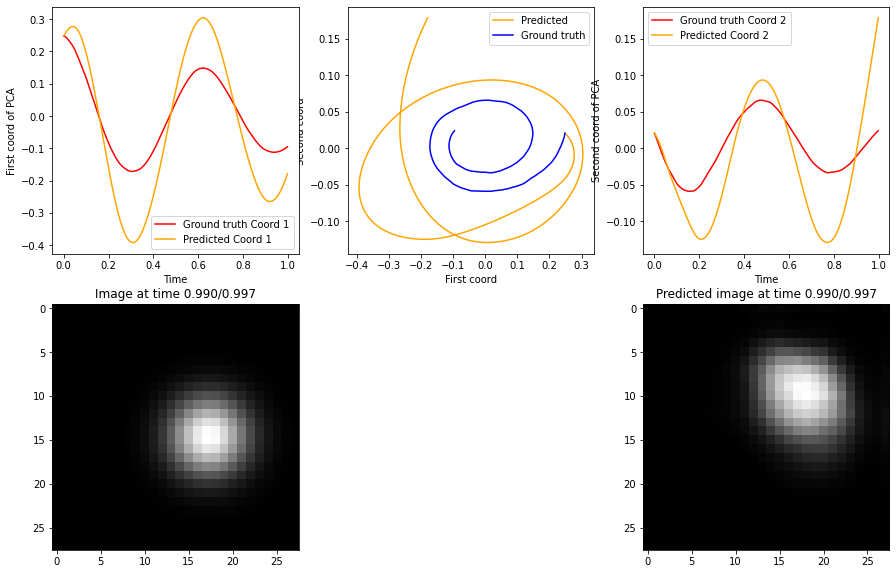

Display loss: 0.00106935:  30%|███       | 15000/50000 [54:31<3:58:42,  2.44it/s, Loss: 0.00066483]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00106935:  32%|███▏      | 15999/50000 [58:09<2:02:44,  4.62it/s, Loss: 0.00097310]

The graphs at epoch 16000


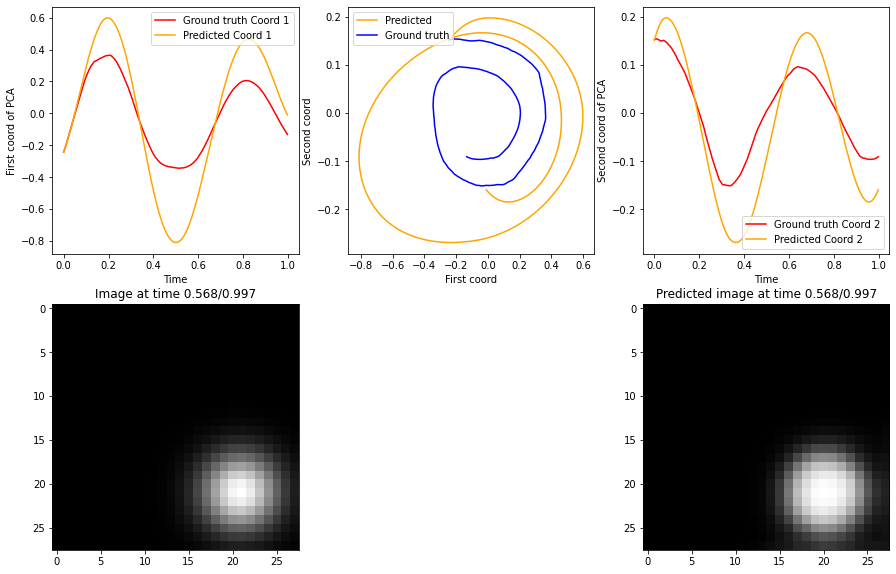

Display loss: 0.00107465:  32%|███▏      | 16000/50000 [58:10<3:41:59,  2.55it/s, Loss: 0.00097310]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00107465:  34%|███▍      | 16999/50000 [1:01:47<2:00:07,  4.58it/s, Loss: 0.00073061]

The graphs at epoch 17000


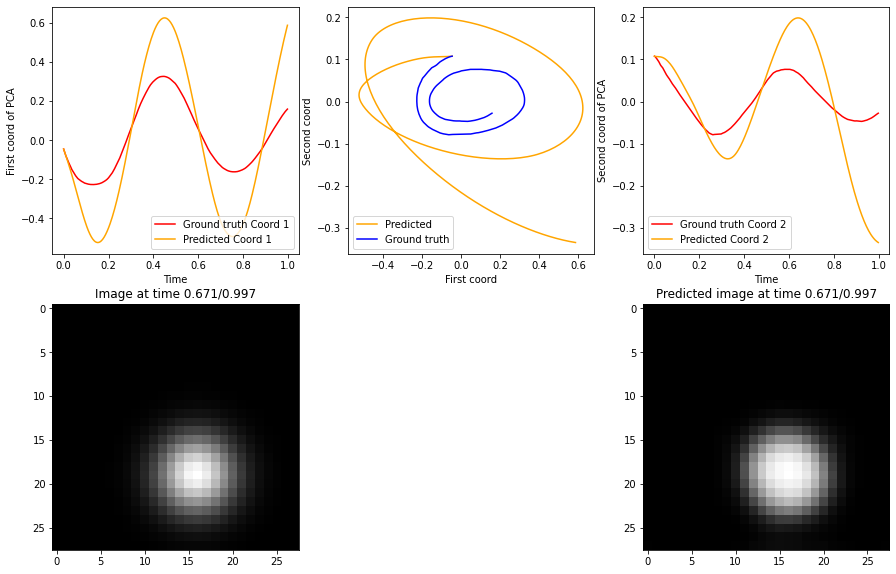

Display loss: 0.00106327:  34%|███▍      | 17000/50000 [1:01:48<3:33:01,  2.58it/s, Loss: 0.00073061]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00106327:  36%|███▌      | 17999/50000 [1:05:25<1:57:03,  4.56it/s, Loss: 0.00190374]

The graphs at epoch 18000


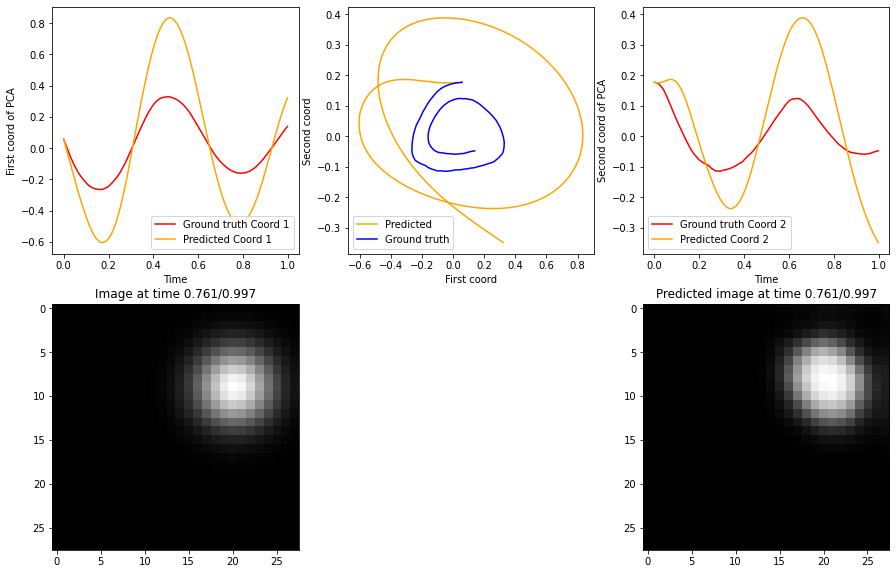

Display loss: 0.00108903:  36%|███▌      | 18000/50000 [1:05:26<3:41:24,  2.41it/s, Loss: 0.00190374]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00108903:  38%|███▊      | 18999/50000 [1:09:04<1:53:05,  4.57it/s, Loss: 0.00076184]

The graphs at epoch 19000


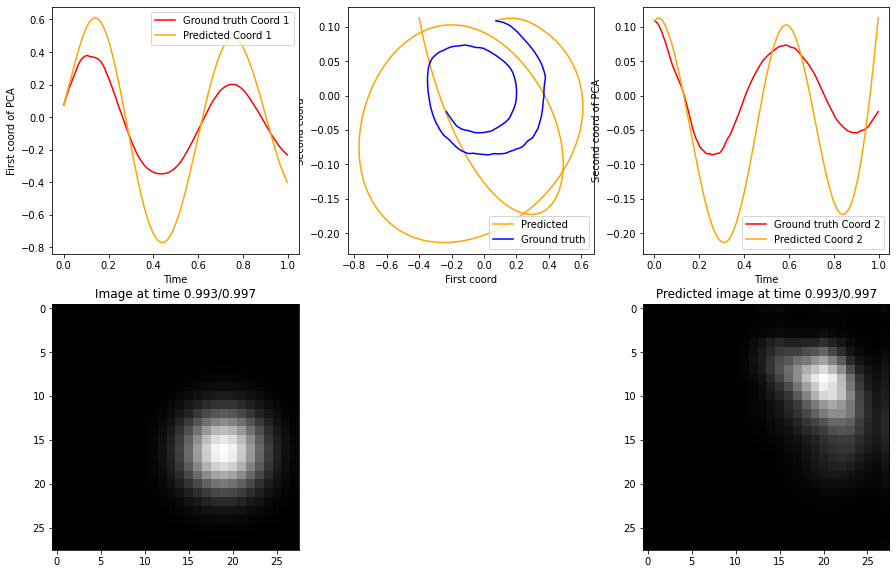

Display loss: 0.00107995:  38%|███▊      | 19000/50000 [1:09:05<3:34:33,  2.41it/s, Loss: 0.00076184]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00107995:  40%|███▉      | 19999/50000 [1:12:43<1:48:50,  4.59it/s, Loss: 0.00112478]

The graphs at epoch 20000


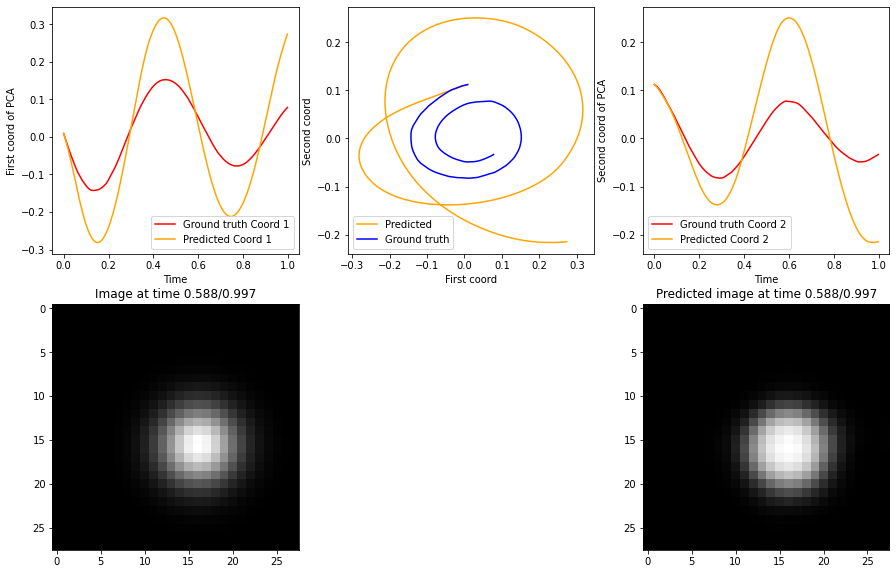

Display loss: 0.00104749:  40%|████      | 20000/50000 [1:12:43<3:12:14,  2.60it/s, Loss: 0.00112478]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00104749:  42%|████▏     | 20999/50000 [1:16:21<1:44:27,  4.63it/s, Loss: 0.00070227]

The graphs at epoch 21000


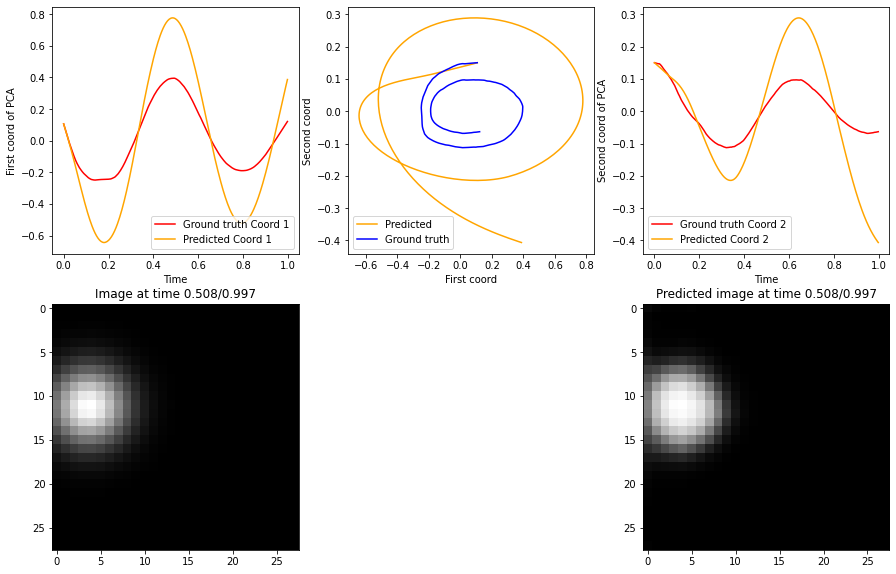

Display loss: 0.00104421:  42%|████▏     | 21000/50000 [1:16:21<3:10:16,  2.54it/s, Loss: 0.00070227]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00104421:  44%|████▍     | 21999/50000 [1:19:59<1:41:57,  4.58it/s, Loss: 0.00113341]

The graphs at epoch 22000


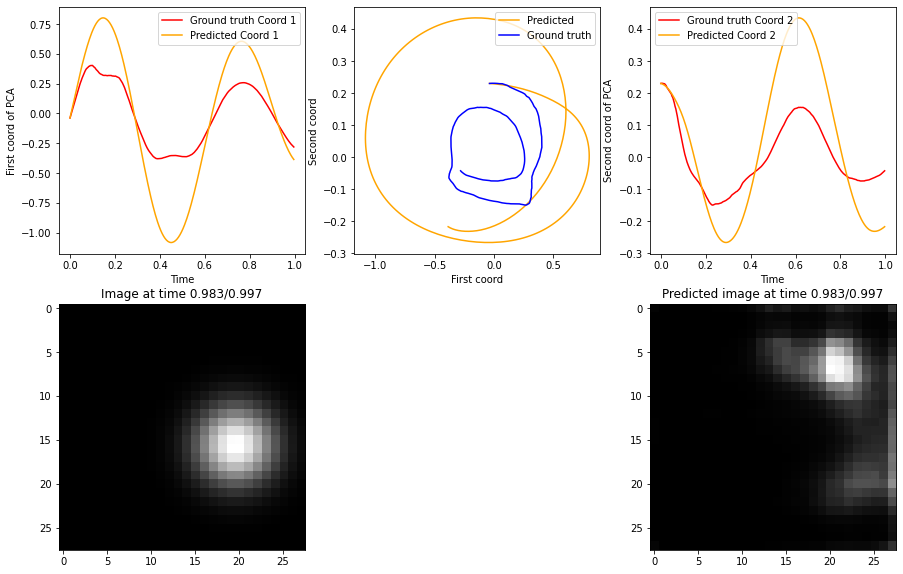

Display loss: 0.00103834:  44%|████▍     | 22000/50000 [1:20:00<3:04:03,  2.54it/s, Loss: 0.00113341]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00103834:  46%|████▌     | 22999/50000 [1:23:36<1:37:49,  4.60it/s, Loss: 0.00093721]

The graphs at epoch 23000


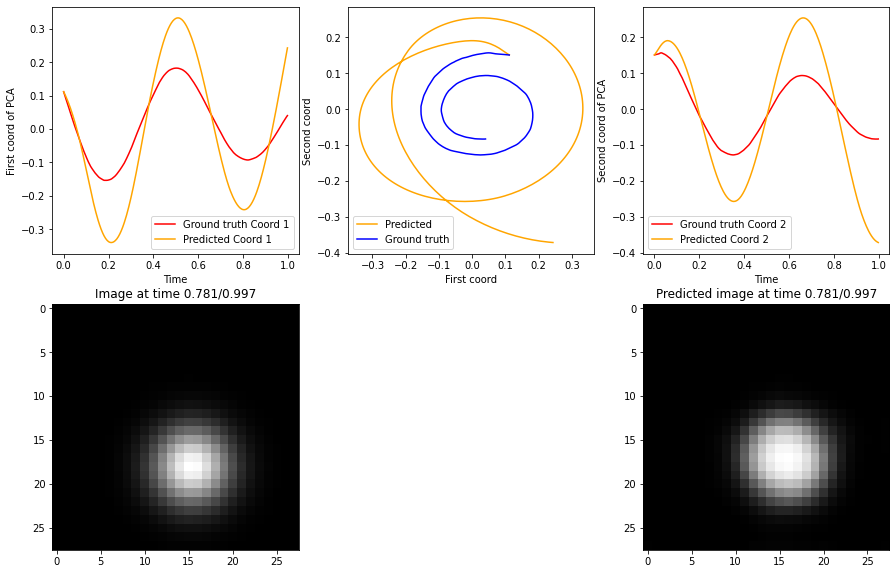

Display loss: 0.00103854:  46%|████▌     | 23000/50000 [1:23:37<2:53:58,  2.59it/s, Loss: 0.00093721]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00103854:  48%|████▊     | 23999/50000 [1:27:13<1:34:17,  4.60it/s, Loss: 0.00137703]

The graphs at epoch 24000


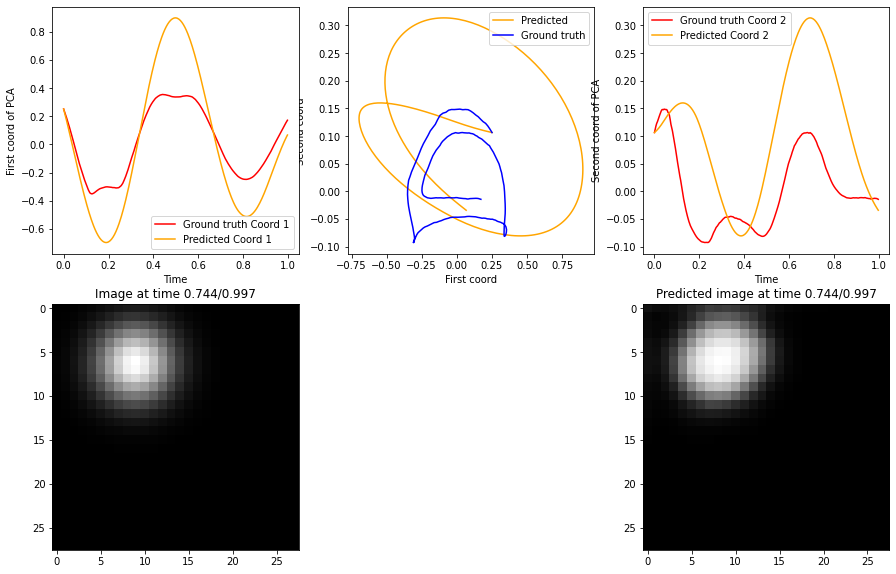

Display loss: 0.00103098:  48%|████▊     | 24000/50000 [1:27:14<3:05:35,  2.33it/s, Loss: 0.00137703]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00103098:  50%|████▉     | 24999/50000 [1:30:50<1:29:59,  4.63it/s, Loss: 0.00090475]

The graphs at epoch 25000


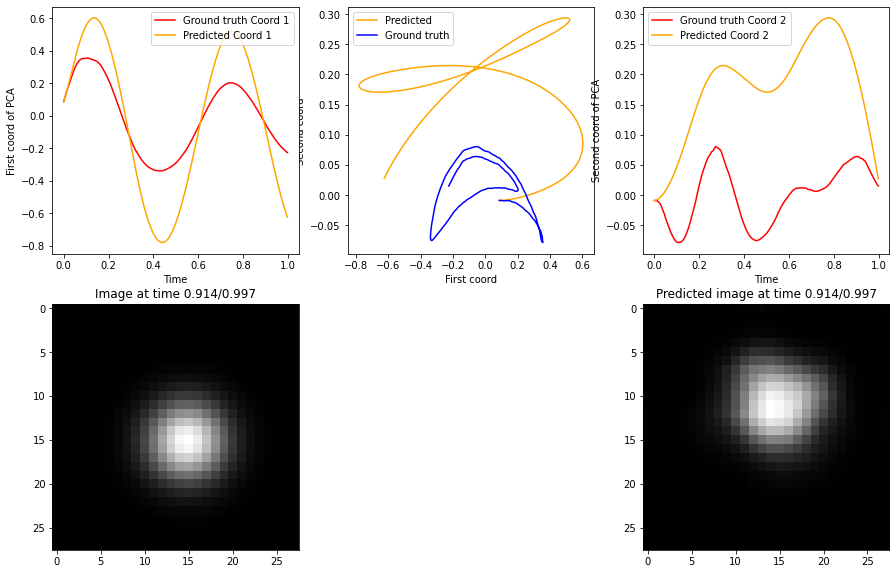

Display loss: 0.00101424:  50%|█████     | 25000/50000 [1:30:51<2:56:39,  2.36it/s, Loss: 0.00090475]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00101424:  52%|█████▏    | 25999/50000 [1:34:27<1:25:21,  4.69it/s, Loss: 0.00086054]

The graphs at epoch 26000


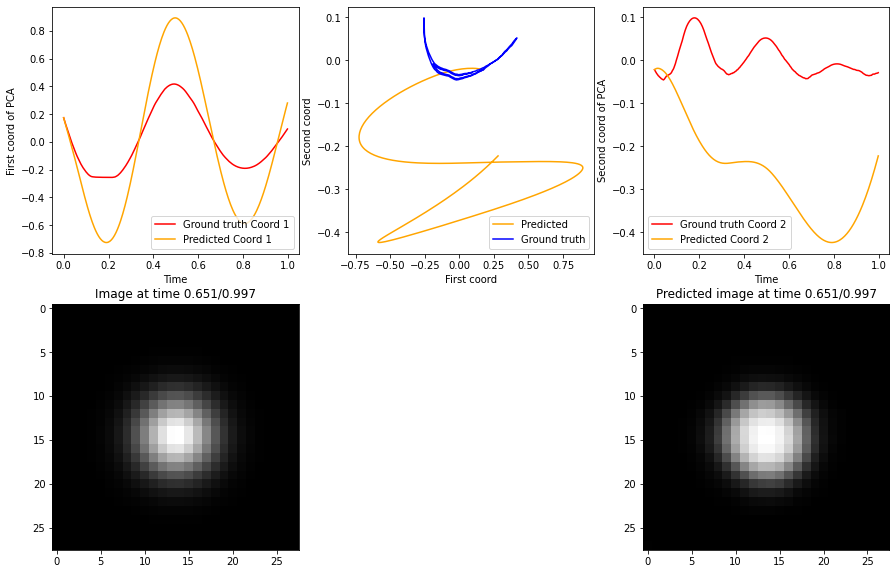

Display loss: 0.00103187:  52%|█████▏    | 26000/50000 [1:34:28<2:42:09,  2.47it/s, Loss: 0.00086054]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00103187:  54%|█████▍    | 26999/50000 [1:38:04<1:22:53,  4.62it/s, Loss: 0.00163941]

The graphs at epoch 27000


Display loss: 0.00101742:  54%|█████▍    | 27000/50000 [1:38:05<2:32:07,  2.52it/s, Loss: 0.00163941]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00101742:  56%|█████▌    | 27999/50000 [1:41:41<1:19:28,  4.61it/s, Loss: 0.00128240]

The graphs at epoch 28000


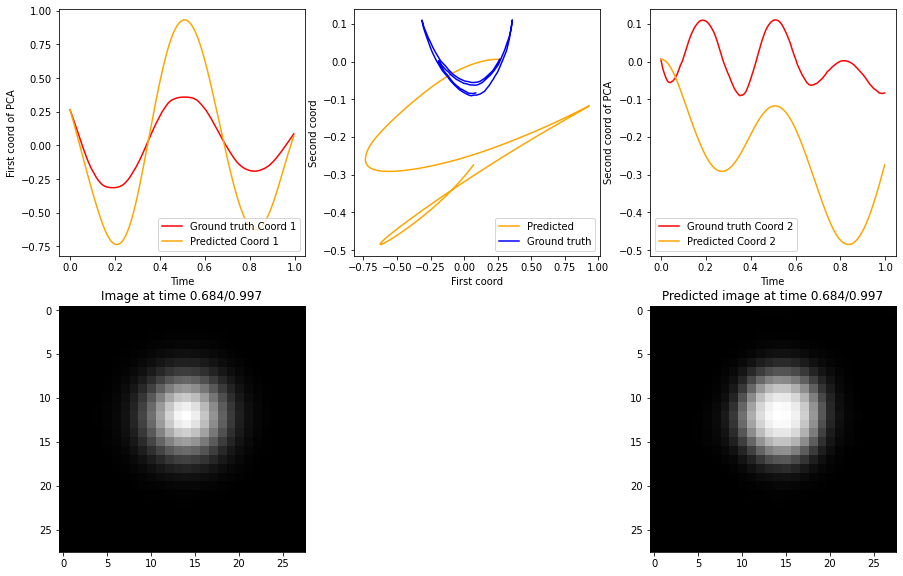

Display loss: 0.00102395:  56%|█████▌    | 28000/50000 [1:41:42<2:34:51,  2.37it/s, Loss: 0.00128240]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00102395:  58%|█████▊    | 28999/50000 [1:45:19<1:15:07,  4.66it/s, Loss: 0.00097349]

The graphs at epoch 29000


Display loss: 0.00100120:  58%|█████▊    | 29000/50000 [1:45:19<2:15:33,  2.58it/s, Loss: 0.00097349]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00100120:  60%|█████▉    | 29999/50000 [1:48:55<1:11:56,  4.63it/s, Loss: 0.00097461]

The graphs at epoch 30000


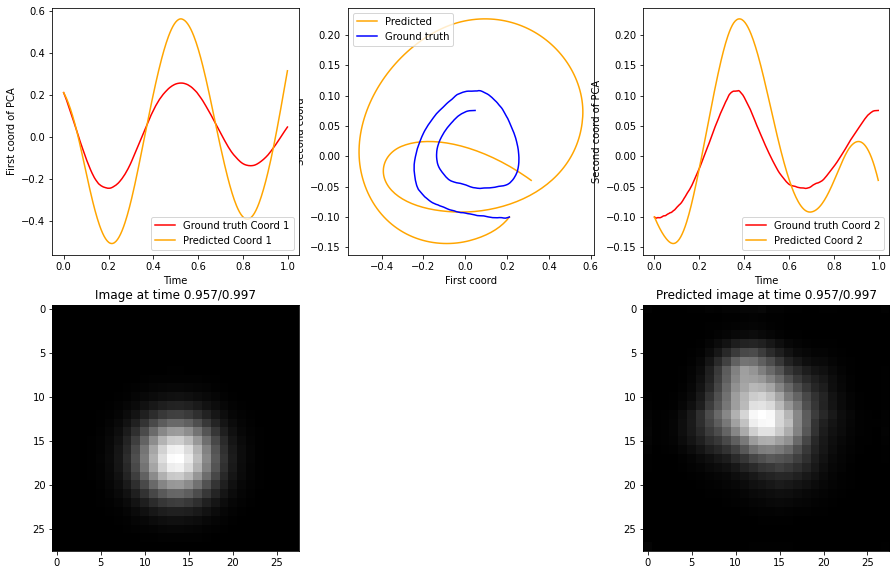

Display loss: 0.00100616:  60%|██████    | 30000/50000 [1:48:56<2:09:36,  2.57it/s, Loss: 0.00097461]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00100616:  62%|██████▏   | 30999/50000 [1:52:32<1:08:36,  4.62it/s, Loss: 0.00123672]

The graphs at epoch 31000


Display loss: 0.00102137:  62%|██████▏   | 31000/50000 [1:52:33<2:01:31,  2.61it/s, Loss: 0.00123672]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00102137:  64%|██████▍   | 31999/50000 [1:56:09<1:04:31,  4.65it/s, Loss: 0.00150999]

The graphs at epoch 32000


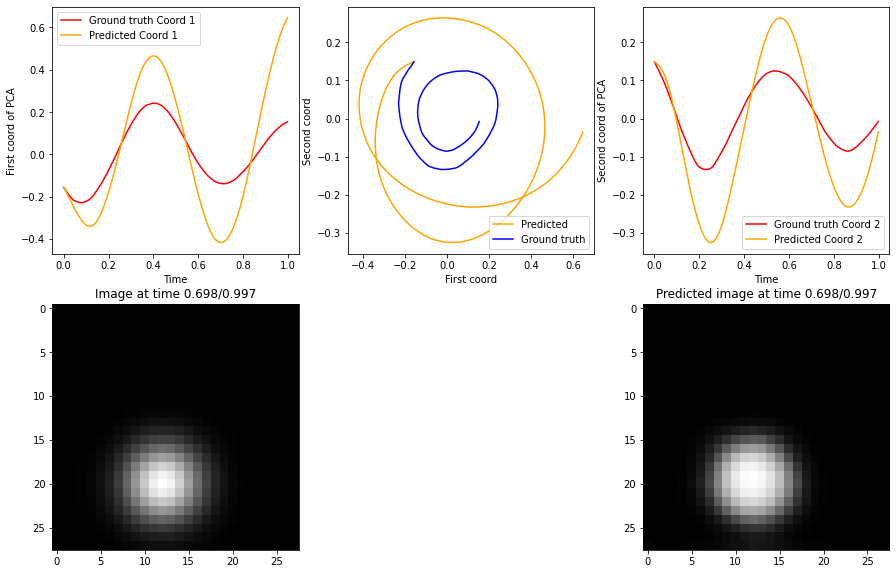

Display loss: 0.00098988:  64%|██████▍   | 32000/50000 [1:56:10<1:54:46,  2.61it/s, Loss: 0.00150999]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00098988:  66%|██████▌   | 32999/50000 [1:59:46<1:01:31,  4.61it/s, Loss: 0.00102246]

The graphs at epoch 33000


Display loss: 0.00102277:  66%|██████▌   | 33000/50000 [1:59:47<1:59:07,  2.38it/s, Loss: 0.00102246]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00102277:  68%|██████▊   | 33999/50000 [2:03:23<57:37,  4.63it/s, Loss: 0.00090403]  

The graphs at epoch 34000


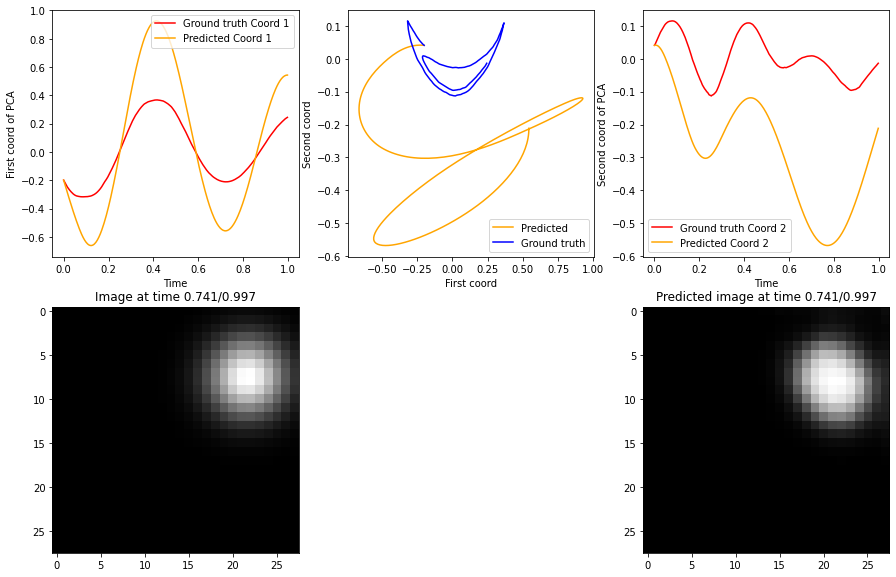

Display loss: 0.00098851:  68%|██████▊   | 34000/50000 [2:03:24<1:51:06,  2.40it/s, Loss: 0.00090403]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00098851:  70%|██████▉   | 34999/50000 [2:07:00<53:31,  4.67it/s, Loss: 0.00162606]  

The graphs at epoch 35000


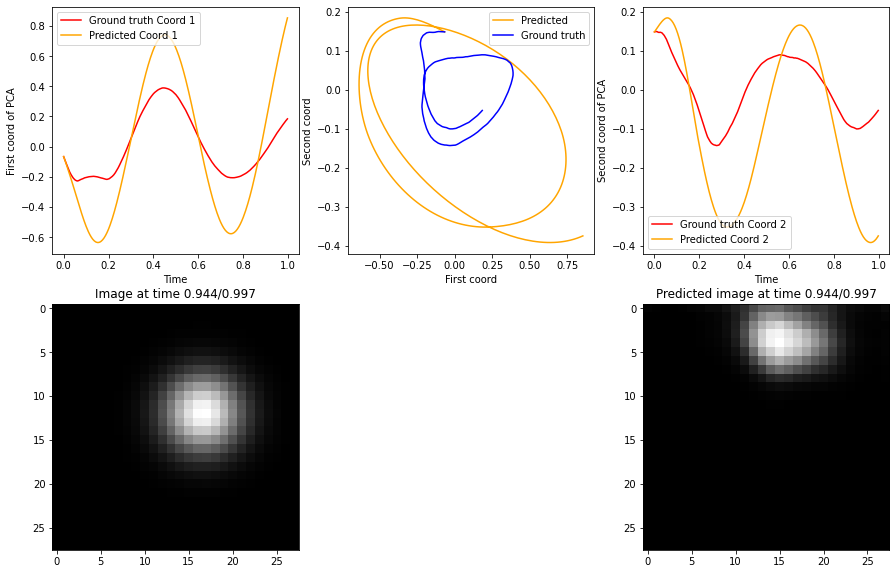

Display loss: 0.00099666:  70%|███████   | 35000/50000 [2:07:01<1:36:38,  2.59it/s, Loss: 0.00162606]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00099666:  72%|███████▏  | 35999/50000 [2:10:37<49:52,  4.68it/s, Loss: 0.00183087]  

The graphs at epoch 36000


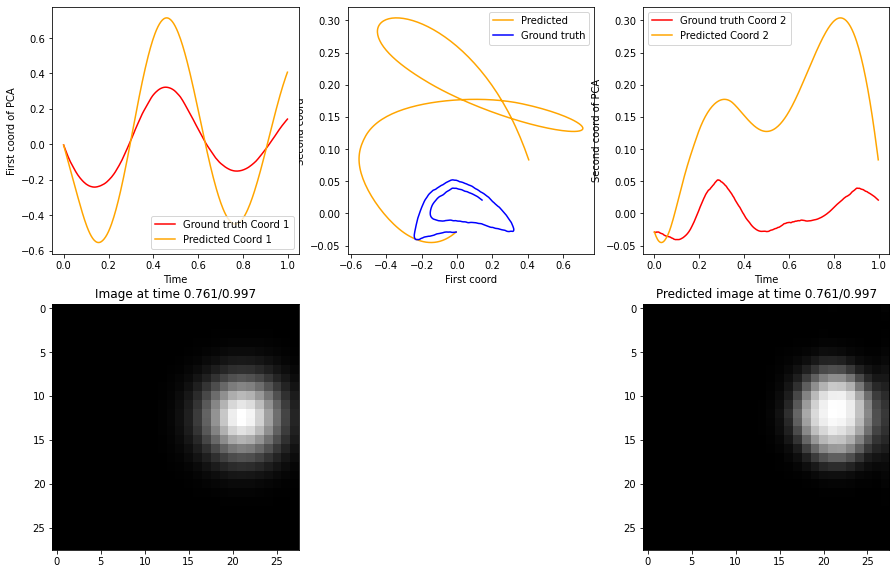

Display loss: 0.00099327:  72%|███████▏  | 36000/50000 [2:10:37<1:34:26,  2.47it/s, Loss: 0.00183087]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00099327:  74%|███████▍  | 36999/50000 [2:14:13<46:56,  4.62it/s, Loss: 0.00057655]  

The graphs at epoch 37000


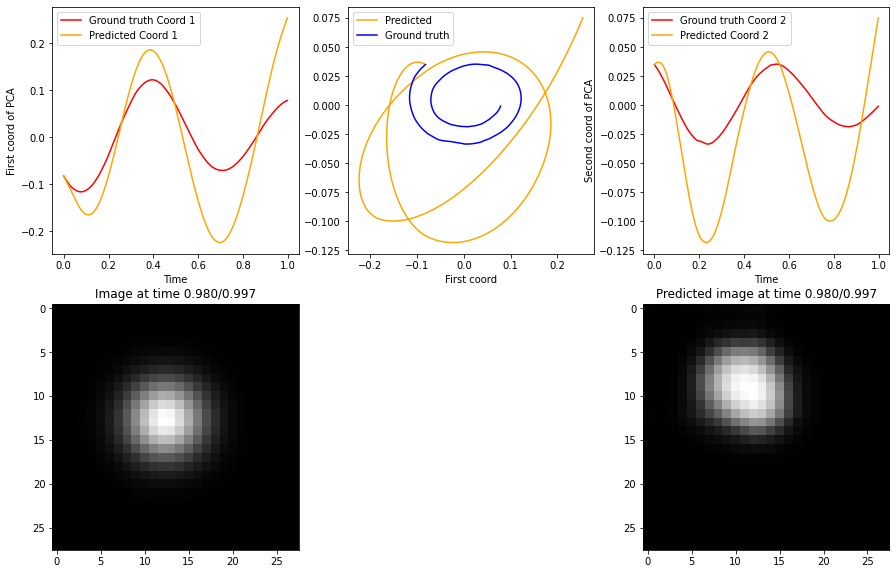

Display loss: 0.00097727:  74%|███████▍  | 37000/50000 [2:14:14<1:23:14,  2.60it/s, Loss: 0.00057655]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00097727:  76%|███████▌  | 37999/50000 [2:17:50<43:27,  4.60it/s, Loss: 0.00104310]  

The graphs at epoch 38000


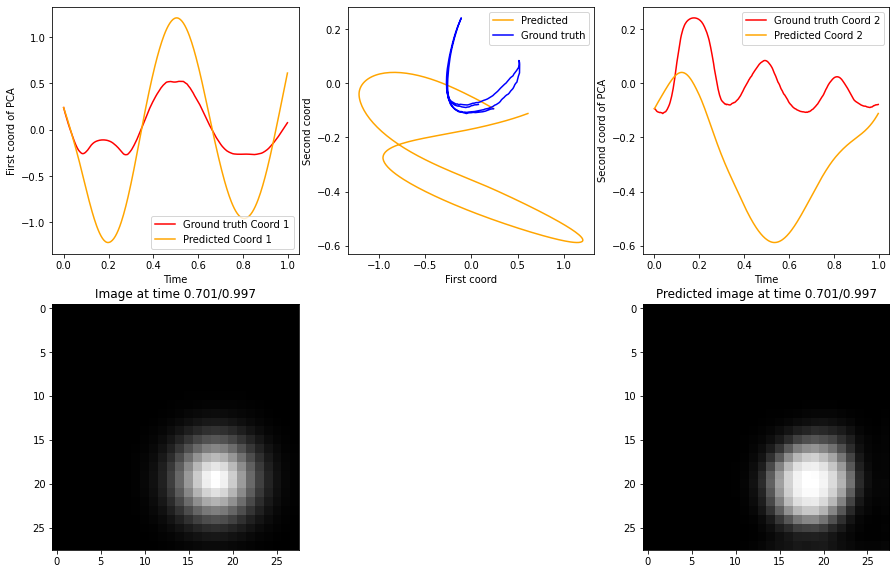

Display loss: 0.00098393:  76%|███████▌  | 38000/50000 [2:17:51<1:16:28,  2.62it/s, Loss: 0.00104310]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00098393:  78%|███████▊  | 38999/50000 [2:21:27<39:36,  4.63it/s, Loss: 0.00072938]  

The graphs at epoch 39000


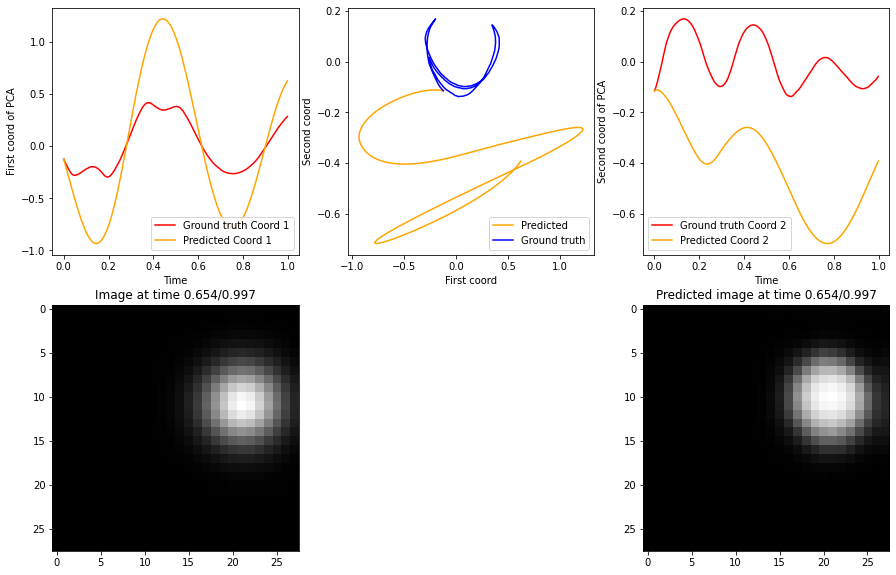

Display loss: 0.00097928:  78%|███████▊  | 39000/50000 [2:21:28<1:09:38,  2.63it/s, Loss: 0.00072938]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00097928:  80%|███████▉  | 39999/50000 [2:25:04<35:47,  4.66it/s, Loss: 0.00107975]  

The graphs at epoch 40000


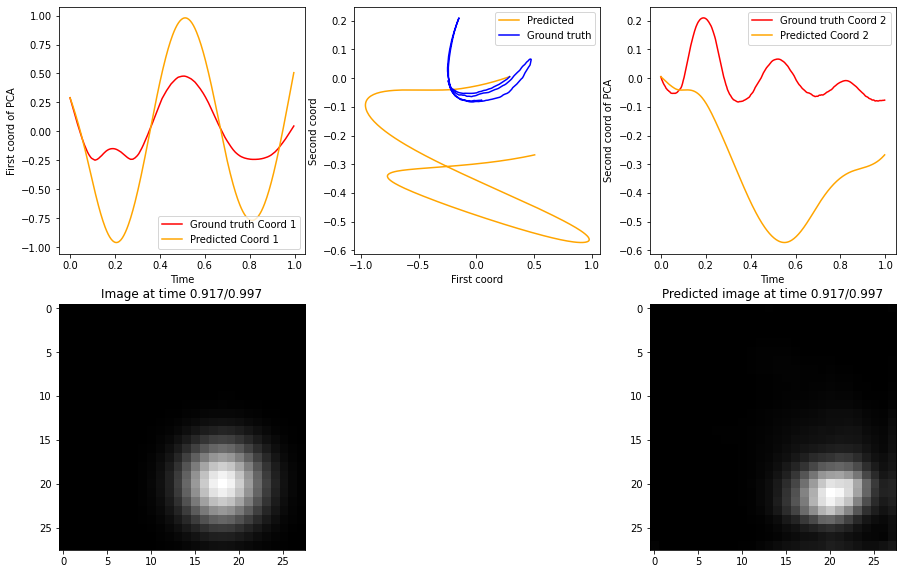

Display loss: 0.00097521:  80%|████████  | 40000/50000 [2:25:04<1:11:05,  2.34it/s, Loss: 0.00107975]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00097521:  82%|████████▏ | 40999/50000 [2:28:41<32:20,  4.64it/s, Loss: 0.00078456]  

The graphs at epoch 41000


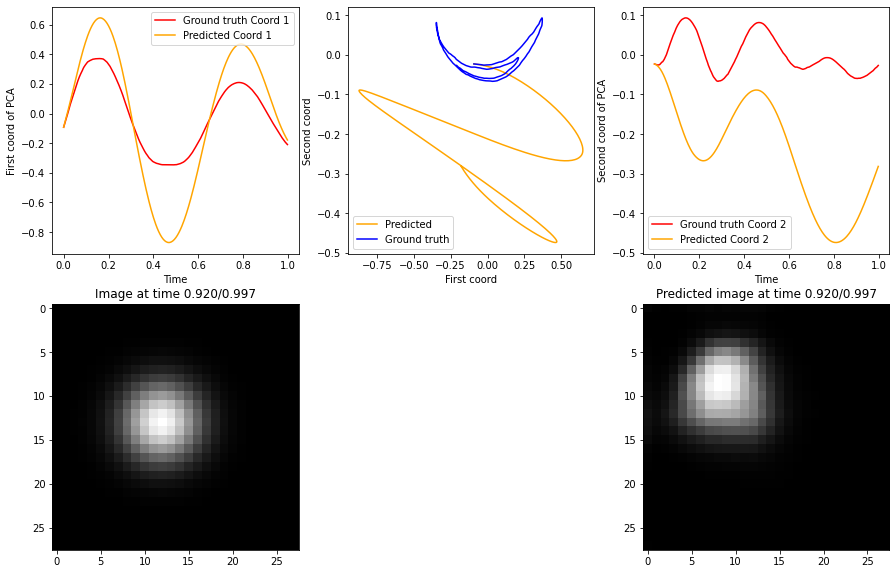

Display loss: 0.00096355:  82%|████████▏ | 41000/50000 [2:28:42<1:01:15,  2.45it/s, Loss: 0.00078456]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00096355:  84%|████████▍ | 41999/50000 [2:32:18<28:53,  4.62it/s, Loss: 0.00086175]  

The graphs at epoch 42000


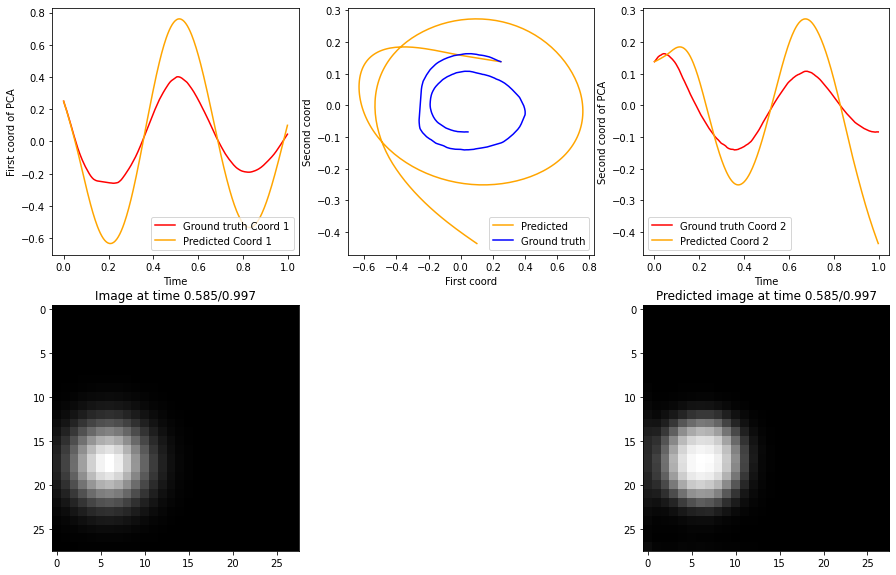

Display loss: 0.00095800:  84%|████████▍ | 42000/50000 [2:32:18<52:04,  2.56it/s, Loss: 0.00086175]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00095800:  86%|████████▌ | 42999/50000 [2:35:55<25:13,  4.63it/s, Loss: 0.00065550]

The graphs at epoch 43000


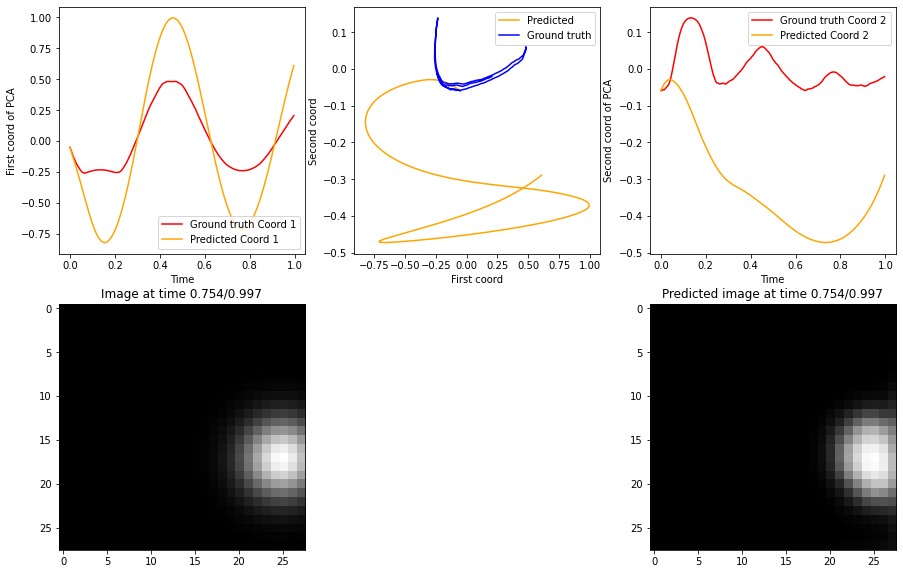

Display loss: 0.00095074:  86%|████████▌ | 43000/50000 [2:35:55<48:52,  2.39it/s, Loss: 0.00065550]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00095074:  88%|████████▊ | 43999/50000 [2:39:32<21:30,  4.65it/s, Loss: 0.00083805]

The graphs at epoch 44000


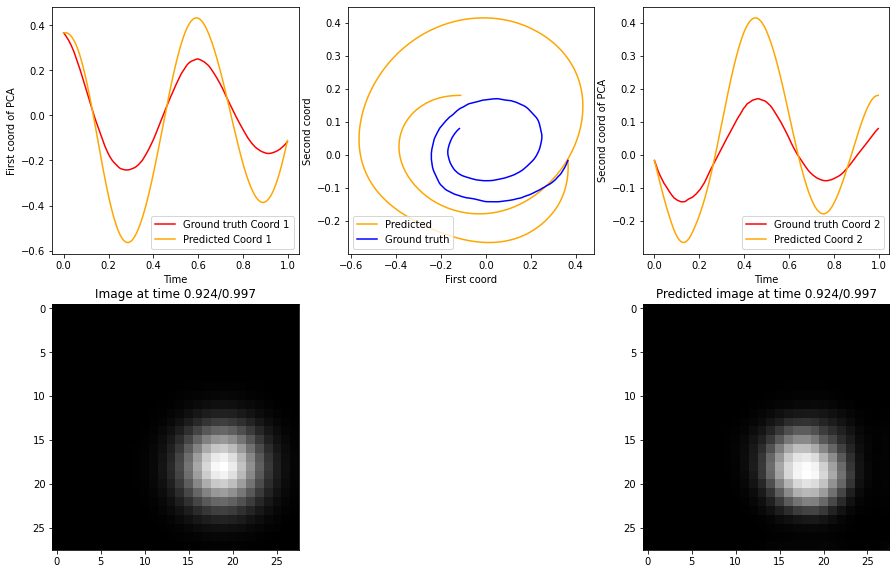

Display loss: 0.00095836:  88%|████████▊ | 44000/50000 [2:39:33<38:42,  2.58it/s, Loss: 0.00083805]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00095836:  90%|████████▉ | 44999/50000 [2:43:08<18:11,  4.58it/s, Loss: 0.00082452]

The graphs at epoch 45000


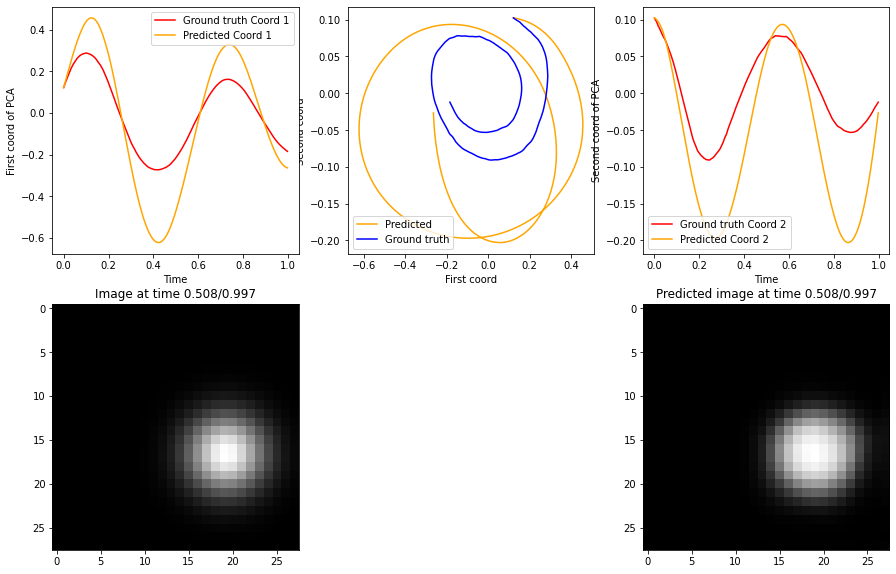

Display loss: 0.00096822:  90%|█████████ | 45000/50000 [2:43:09<32:31,  2.56it/s, Loss: 0.00082452]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00096822:  92%|█████████▏| 45999/50000 [2:46:46<14:25,  4.62it/s, Loss: 0.00121551]

The graphs at epoch 46000


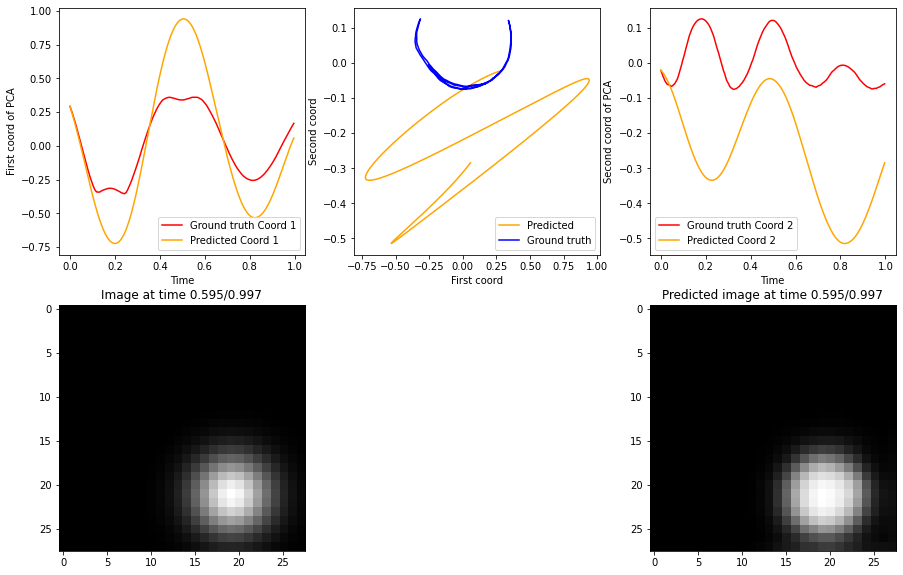

Display loss: 0.00095528:  92%|█████████▏| 46000/50000 [2:46:47<27:58,  2.38it/s, Loss: 0.00121551]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00095528:  94%|█████████▍| 46999/50000 [2:50:23<10:44,  4.65it/s, Loss: 0.00063159]

The graphs at epoch 47000


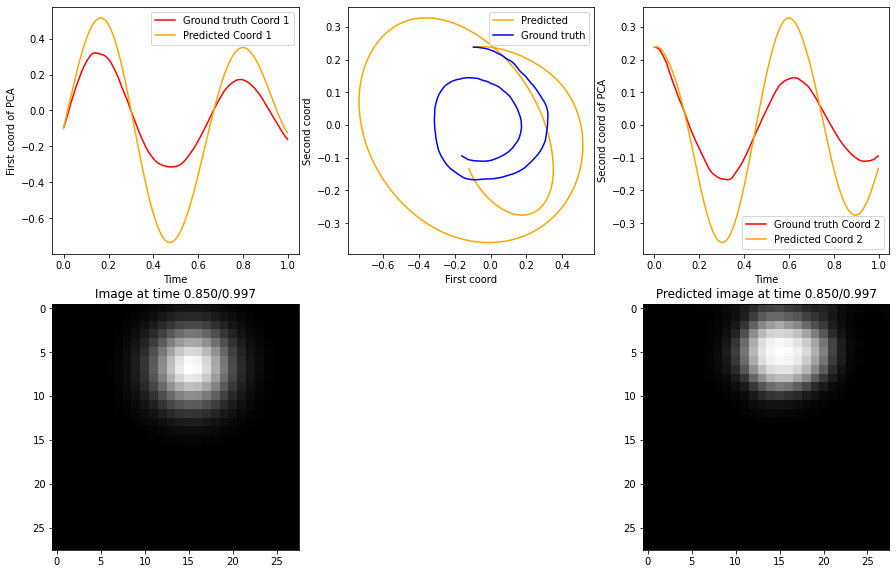

Display loss: 0.00095695:  94%|█████████▍| 47000/50000 [2:50:24<19:20,  2.58it/s, Loss: 0.00063159]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00095695:  96%|█████████▌| 47999/50000 [2:54:00<07:06,  4.69it/s, Loss: 0.00061430]

The graphs at epoch 48000


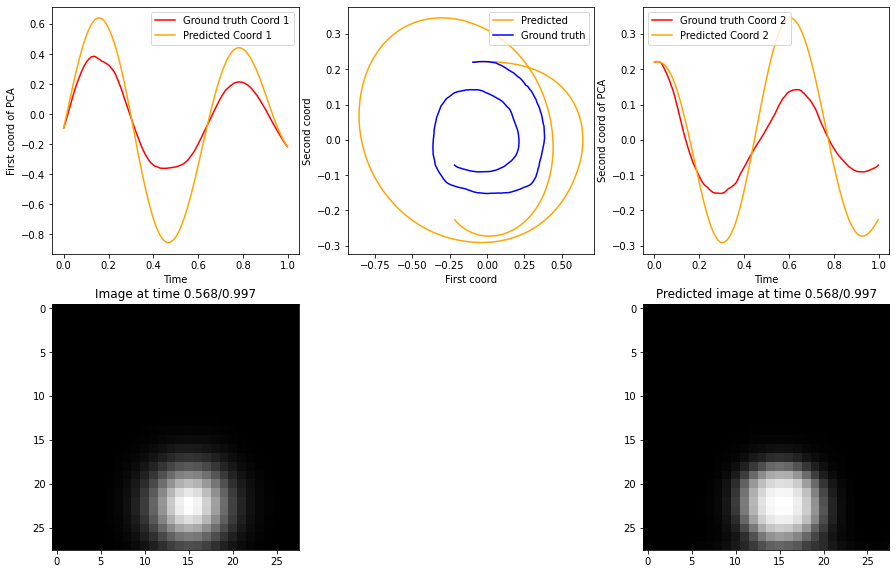

Display loss: 0.00094669:  96%|█████████▌| 48000/50000 [2:54:01<13:31,  2.46it/s, Loss: 0.00061430]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00094669:  98%|█████████▊| 48999/50000 [2:57:37<03:38,  4.59it/s, Loss: 0.00057572]

The graphs at epoch 49000


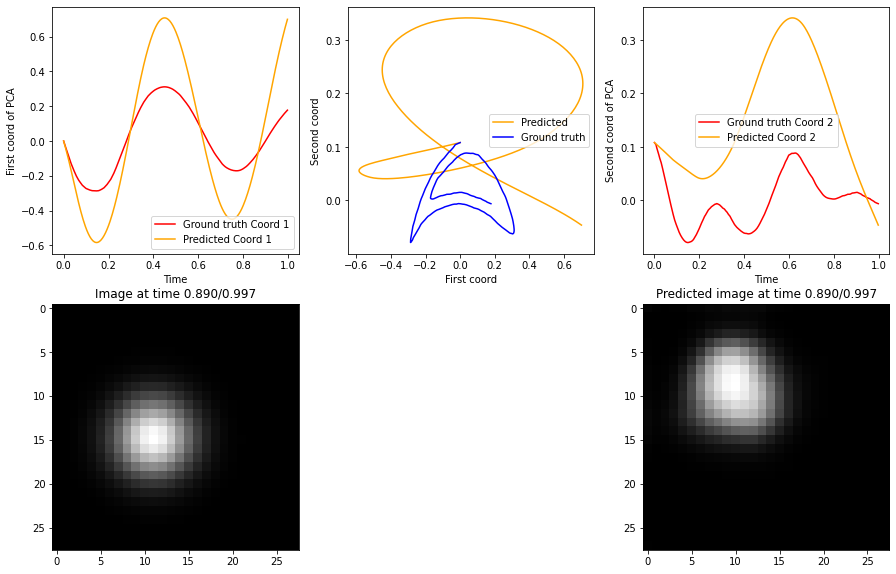

Display loss: 0.00094892:  98%|█████████▊| 49000/50000 [2:57:38<06:28,  2.57it/s, Loss: 0.00057572]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


Display loss: 0.00094892: 100%|█████████▉| 49999/50000 [3:01:14<00:00,  4.60it/s, Loss: 0.00127336]

The graphs at epoch 50000


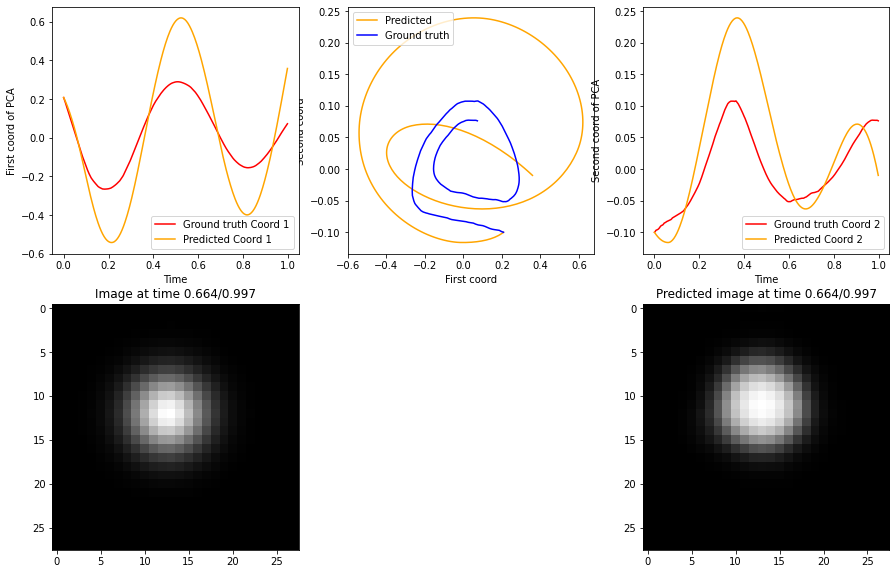

Display loss: 0.00094471: 100%|██████████| 50000/50000 [3:01:15<00:00,  4.60it/s, Loss: 0.00127336]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0
-------------------------------------------------------------------------


In [8]:
print("-"*50)
print("Training...")
epochs = 50000

# for param in conv_ode.node.parameters():
#     param.requires_grad = True
    
train_convnode_with_batch(conv_ode, optimizers, scheduler, epochs,
    getter, loss_fn=loss_fn, display=1000, display_results_fn=display_fn)

In [9]:
pathConvODE = "conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}_last_model_no_reg.pt".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
torch.save(conv_ode.state_dict(), pathConvODE)

In [10]:
# To continue training :
print(loss_fn.reg_lambda)
print(optimizerODE)

0.0
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 1e-05
    lr: 7.17897987691853e-07
    weight_decay: 0
)


--------------------------------------------------
Training...


  3%|▎         | 997/30000 [00:24<11:17, 42.82it/s, Loss: 0.00136569]

The graphs at epoch 1000


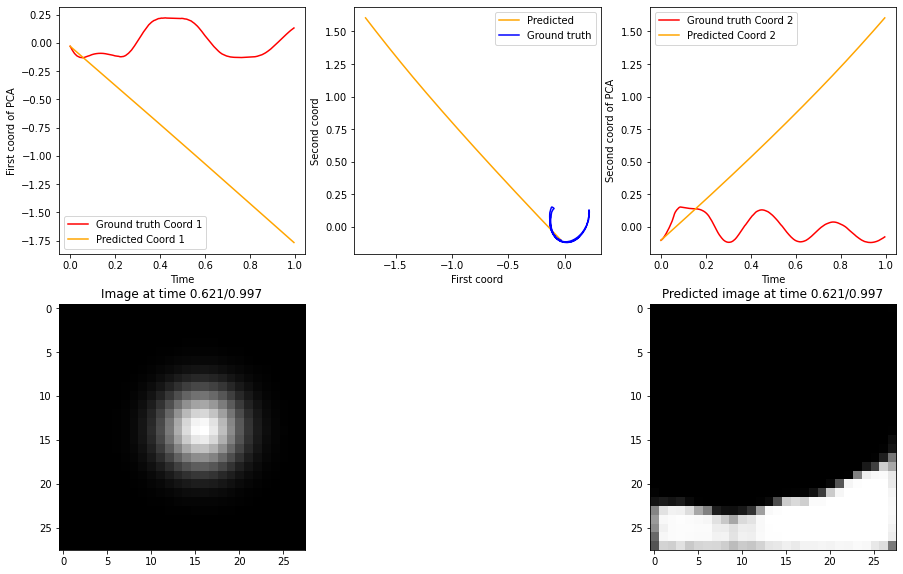

Display loss: 0.00494316:   3%|▎         | 1007/30000 [00:24<22:50, 21.16it/s, Loss: 0.00239880]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0.0002, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0016384000000000004
-------------------------------------------------------------------------


Display loss: 0.00494316:   5%|▍         | 1426/30000 [00:34<11:34, 41.14it/s, Loss: 0.00245312]


KeyboardInterrupt: 

In [9]:
print("-"*50)
print("Training...")
for param in conv_ode.encoder.parameters():
    param.requires_grad = False

for param in conv_ode.decoder.parameters():
    param.requires_grad = False

# loss_fn.reg_lambda = 0.
optimizer = torch.optim.Adam(conv_ode.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)

epochs = 30000
train_convnode_with_batch(conv_ode, optimizer, scheduler, epochs,
    getter, loss_fn=loss_fn, display=1000, display_results_fn=display_fn)

In [28]:
pathConvODE = "conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}_with_lambda_decay_ODE_and_decoder_new_loss_sep_and_jointly.pt".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
torch.save(conv_ode.state_dict(), pathConvODE)

In [11]:
from skimage.color import gray2rgb

def generate_interactive_plot(i, model, out_display, getter, final_time, dt, root=None, name=None):

    index = np.random.randint(0, getter.N_train)
    time_steps = np.linspace(0, final_time*dt, final_time)

    times = torch.arange(0, final_time*dt, dt)

    gd_images = getter.train_images[index, :-1][:,0].cpu().numpy()
    input_images = getter.train_images[index, :2]
    with torch.no_grad():
        reconstructed_images, _ = model(input_images.to(device), times.to(device), dt)
        reconstructed_images = reconstructed_images.cpu().numpy()

    print("Sim", reconstructed_images.shape, gd_images.shape)

    gd_images = np.expand_dims(gd_images, axis=1)
    reconstructed_images = np.expand_dims(reconstructed_images[:,0], axis=1)
    print("Extract Gray", gd_images.shape, reconstructed_images.shape)

    gd_images = np.array([gray2rgb(img[0]) for img in gd_images])
    gd_images = 200*(gd_images - gd_images.min())/(gd_images.max() - gd_images.min())
    print("Gray to rgb for gd_images", gd_images.shape, reconstructed_images.shape)

    reconstructed_images = np.array([gray2rgb(img[0]) for img in reconstructed_images])
    reconstructed_images = 200*(reconstructed_images - reconstructed_images.min())/(reconstructed_images.max() - reconstructed_images.min())

    print("Gray to rgb for reconstructed", gd_images.shape, reconstructed_images.shape)

    return interactive_part_trajectory_image_plot(gd_images, reconstructed_images, time_steps, dt)


def interactive_part_trajectory_image_plot(inputs_images, reconstructed_images, time_steps, dt):
    fig = make_subplots(rows=1, cols=3, subplot_titles=("Input image", "Predicted image"))
    fig = go.FigureWidget(fig)
    # add a black background to the figure
    fig.add_image(z=inputs_images[0], row=1, col=1, name='true image')
    fig.add_image(z=reconstructed_images[0], row=1, col=2, name='predicted image')

    N_max_input = len(inputs_images)-1
    N_max_predicted = len(reconstructed_images)-1
    N_max = max(N_max_input, N_max_predicted)

    frac_input = 1. #N_max/N_max_predicted
    frac_predicted = 1. #N_max/N_max_input

    @interact(t=(time_steps.min(),time_steps.max(),dt))
    def update_plot(t):
        with fig.batch_update():
            # change the current point of 
            print(t/dt)
            print(int(frac_input*t/dt))
            print(int(frac_predicted*t/dt))
            fig.data[0].z = inputs_images[min(int(frac_input*t/dt), N_max_input)]
            fig.data[1].z = reconstructed_images[min(int(frac_predicted*t/dt), N_max_predicted)]

    return fig

In [12]:
fig = generate_interactive_plot(0, conv_ode, 0, getter, N_frames - Num_pos_velocity, dt, root=None, name=None)
fig

Sim (300, 3, 28, 28) (300, 28, 28)
Extract Gray (300, 1, 28, 28) (300, 1, 28, 28)
Gray to rgb for gd_images (300, 28, 28, 3) (300, 1, 28, 28)
Gray to rgb for reconstructed (300, 28, 28, 3) (300, 28, 28, 3)


interactive(children=(FloatSlider(value=0.4983388704318937, description='t', max=0.9966777408637874, step=0.00…

FigureWidget({
    'data': [{'name': 'true image',
              'type': 'image',
              'uid': '8ee8b9…